In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import os
from binance.client import Client, HistoricalKlinesType
import pandas as pd
import requests
import zipfile
import io

client = Client()


def is_kline_data_exists(exchange, trading_pair, date, kline_interval):
    file_name = f"{trading_pair}_{date}_{kline_interval}.csv"
    file_path = os.path.join("kline", exchange, trading_pair, kline_interval, file_name)

    if os.path.exists(file_path):
        # print(f"Data exists: {file_path}")
        return True
    else:
        # print(f"Data does not exist: {file_path}")
        return False


def fetch_kline_from_api(symbol, interval, date):
    # Build start and end time, and set to UTC+0 timezone
    start_str = f"{date} 00:00:00"
    end_str = f"{date} 23:59:59"

    # Get klines from Binance API
    klines = client.get_historical_klines(symbol, interval, start_str, end_str, klines_type=HistoricalKlinesType.FUTURES)

    # Convert data to DataFrame
    df = pd.DataFrame(
        klines,
        columns=[
            "open_time",
            "open",
            "high",
            "low",
            "close",
            "volume",
            "close_time",
            "quote_asset_volume",
            "number_of_trades",
            "taker_buy_base_asset_volume",
            "taker_buy_quote_asset_volume",
            "ignore",
        ],
    )

    # Convert timestamp to datetime format
    df["open_time"] = pd.to_datetime(df["open_time"], unit="ms")
    df["close_time"] = pd.to_datetime(df["close_time"], unit="ms")

    # Convert data type
    df[["open", "high", "low", "close", "volume"]] = df[["open", "high", "low", "close", "volume"]].astype(float)

    return df

def fetch_1s_kline_from_binance_data(trading_pair, date):
    """
    从 Binance Data 下载 1s K线数据
    date 格式: YYYY-MM-DD
    """
    # 转换日期格式从 YYYY-MM-DD 到 YYYY-MM-DD
    date_parts = date.split('-')
    formatted_date = f"{date_parts[0]}-{date_parts[1]}-{date_parts[2]}"
    
    # 构建下载URL
    url = f"https://data.binance.vision/data/spot/daily/klines/{trading_pair}/1s/{trading_pair}-1s-{formatted_date}.zip"
    
    try:
        # 下载ZIP文件
        response = requests.get(url)
        response.raise_for_status()
        
        # 解压ZIP文件并读取CSV
        with zipfile.ZipFile(io.BytesIO(response.content)) as zip_file:
            csv_filename = zip_file.namelist()[0]  # 获取ZIP中的CSV文件名
            with zip_file.open(csv_filename) as csv_file:
                df = pd.read_csv(csv_file, header=None, names=[
                    "open_time", "open", "high", "low", "close", "volume",
                    "close_time", "quote_asset_volume", "number_of_trades",
                    "taker_buy_base_asset_volume", "taker_buy_quote_asset_volume", "ignore"
                ])
        
        # 转换时间戳为datetime格式
        df["open_time"] = pd.to_datetime(df["open_time"], unit="ms")
        df["close_time"] = pd.to_datetime(df["close_time"], unit="ms")
        
        # 转换数据类型
        df[["open", "high", "low", "close", "volume"]] = df[["open", "high", "low", "close", "volume"]].astype(float)
        
        return df
    
    except Exception as e:
        print(f"下载1s数据时发生错误: {e}")
        return pd.DataFrame()
    
def get_kline(exchange, trading_pair, date, kline_interval):
    file_name = f"{trading_pair}_{date}_{kline_interval}.csv"
    file_path = os.path.join("kline", exchange, trading_pair, kline_interval, file_name)

    os.makedirs(os.path.dirname(file_path), exist_ok=True)

    if not is_kline_data_exists(exchange, trading_pair, date, kline_interval):
        if kline_interval == "1s":
            df = fetch_1s_kline_from_binance_data(trading_pair, date)
        else:
            df = fetch_kline_from_api(trading_pair, kline_interval, date)

        if not df.empty:
            df.to_csv(file_path, index=False)
            print(f"K线数据已保存到: {file_path}")

In [3]:
def get_kline(exchange, trading_pair, date, kline_interval):
    file_name = f"{trading_pair}_{date}_{kline_interval}.csv"
    file_path = os.path.join("kline", exchange, trading_pair, kline_interval, file_name)

    os.makedirs(os.path.dirname(file_path), exist_ok=True)

    if not is_kline_data_exists(exchange, trading_pair, date, kline_interval):
        if kline_interval == "1s":
            df = fetch_1s_kline_from_binance_data(trading_pair, date)
        else:
            df = fetch_kline_from_api(trading_pair, kline_interval, date)

        if not df.empty:
            df.to_csv(file_path, index=False)
            print(f"K线数据已保存到: {file_path}")
        else:
            print("Fetched data is empty.")
            return pd.DataFrame()  # Return an empty DataFrame if fetch failed.
    else:
        # If the file exists, read it
        df = pd.read_csv(file_path)
        # Convert time columns to datetime if needed
        if 'open_time' in df.columns:
            df["open_time"] = pd.to_datetime(df["open_time"])
        if 'close_time' in df.columns:
            df["close_time"] = pd.to_datetime(df["close_time"])
    
    return df

In [4]:
# Example function to aggregate kline data over a date range
def fetch_and_aggregate_kline_data(exchange, trading_pair, start_date, end_date, kline_interval="1m"):
    """
    Fetches kline data for each day in the given date range and aggregates them into a single DataFrame.
    
    Parameters:
        exchange (str): The exchange name (e.g., "binance").
        trading_pair (str): The trading pair (e.g., "BTCUSDT").
        start_date (str): Start date in "YYYY-MM-DD" format.
        end_date (str): End date in "YYYY-MM-DD" format.
        kline_interval (str): The interval for the kline data (default "1m" for minute-level).
    
    Returns:
        pd.DataFrame: Aggregated kline data for the date range.
    """
    # Generate a date range (one entry per day)
    dates = pd.date_range(start=start_date, end=end_date, freq="D")
    data_list = []
    
    for d in dates:
        date_str = d.strftime("%Y-%m-%d")
        print(f"Fetching data for {date_str}...")
        # Call your existing get_kline function; it will fetch or load data from file if available
        daily_data = get_kline(exchange, trading_pair, date_str, kline_interval)
        if daily_data is not None and not daily_data.empty:
            data_list.append(daily_data)
        else:
            print(f"No data for {date_str}.")
    
    if data_list:
        aggregated_data = pd.concat(data_list, ignore_index=True)
    else:
        aggregated_data = pd.DataFrame()
    
    return aggregated_data

# Set your parameters:
exchange = "binance"
trading_pair = "BTCUSDT"
start_date = "2024-01-01"
end_date = "2025-09-28"
kline_interval = "1m"  # 60 Minute-level data

# Fetch and aggregate the data
btc_minute_data = fetch_and_aggregate_kline_data(exchange, trading_pair, start_date, end_date, kline_interval)

# Check if data was successfully aggregated
if btc_minute_data.empty:
    print("No kline data was fetched for the specified date range.")
else:
    print(f"Aggregated data shape: {btc_minute_data.shape}")
    # Save the aggregated data to a CSV file
    output_file = f"{trading_pair}_{kline_interval}_{start_date}_to_{end_date}.csv"
    btc_minute_data.to_csv(output_file, index=False)
    print(f"Aggregated kline data saved to: {output_file}")

Fetching data for 2024-01-01...
Fetching data for 2024-01-02...
Fetching data for 2024-01-03...
Fetching data for 2024-01-04...
Fetching data for 2024-01-05...
Fetching data for 2024-01-06...
Fetching data for 2024-01-07...
Fetching data for 2024-01-08...
Fetching data for 2024-01-09...
Fetching data for 2024-01-10...
Fetching data for 2024-01-11...
Fetching data for 2024-01-12...
Fetching data for 2024-01-13...
Fetching data for 2024-01-14...
Fetching data for 2024-01-15...
Fetching data for 2024-01-16...
Fetching data for 2024-01-17...
Fetching data for 2024-01-18...
Fetching data for 2024-01-19...
Fetching data for 2024-01-20...
Fetching data for 2024-01-21...
Fetching data for 2024-01-22...
Fetching data for 2024-01-23...
Fetching data for 2024-01-24...
Fetching data for 2024-01-25...
Fetching data for 2024-01-26...
Fetching data for 2024-01-27...
Fetching data for 2024-01-28...
Fetching data for 2024-01-29...
Fetching data for 2024-01-30...
Fetching data for 2024-01-31...
Fetching

In [10]:
csv_file = "BTCUSDT_1m_2024-01-01_to_2025-09-28.csv"
btc = pd.read_csv(csv_file)

# Print the first 5 rows of the DataFrame
btc

,open_time,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,ignore
0,2024-01-01 00:00:00,42314.0,42335.8,42289.6,42331.9,289.641,2024-01-01 00:00:59.999,1.225616e+07,3310,175.211,7.414460e+06,0
1,2024-01-01 00:01:00,42331.9,42353.1,42331.8,42350.4,202.444,2024-01-01 00:01:59.999,8.572241e+06,1885,154.353,6.535805e+06,0
2,2024-01-01 00:02:00,42350.4,42370.8,42349.6,42360.2,271.521,2024-01-01 00:02:59.999,1.150139e+07,2143,193.034,8.176843e+06,0
3,2024-01-01 00:03:00,42360.1,42405.8,42360.1,42405.8,392.238,2024-01-01 00:03:59.999,1.662644e+07,3551,332.749,1.410472e+07,0
4,2024-01-01 00:04:00,42405.7,42437.2,42405.7,42437.1,568.366,2024-01-01 00:04:59.999,2.411261e+07,4479,419.524,1.779786e+07,0
...,...,...,...,...,...,...,...,...,...,...,...,...
916881,2025-09-28 17:21:00,110200.0,110200.1,110142.6,110142.7,77.426,2025-09-28 17:21:59.999,8.530380e+06,1665,34.050,3.751571e+06,0
916882,2025-09-28 17:22:00,110142.6,110170.8,110142.6,110147.3,62.402,2025-09-28 17:22:59.999,6.874258e+06,1399,23.558,2.595116e+06,0
916883,2025-09-28 17:23:00,110147.4,110163.7,110132.7,110132.8,102.948,2025-09-28 17:23:59.999,1.133923e+07,1336,18.284,2.013948e+06,0
916884,2025-09-28 17:24:00,110132.8,110154.0,110100.4,110102.7,141.968,2025-09-28 17:24:59.999,1.563410e+07,2667,63.197,6.960010e+06,0


In [17]:
# Compute log return
btc['log_return'] = np.log(btc['close'] / btc['close'].shift(1))

In [5]:
# Drop a single column
btc = btc.drop('ignore', axis=1)
btc

,open_time,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,log_return
0,2024-01-01 00:00:00,42314.0,42335.8,42289.6,42331.9,289.641,2024-01-01 00:00:59.999,1.225616e+07,3310,175.211,7.414460e+06,NaN
1,2024-01-01 00:01:00,42331.9,42353.1,42331.8,42350.4,202.444,2024-01-01 00:01:59.999,8.572241e+06,1885,154.353,6.535805e+06,0.000437
2,2024-01-01 00:02:00,42350.4,42370.8,42349.6,42360.2,271.521,2024-01-01 00:02:59.999,1.150139e+07,2143,193.034,8.176843e+06,0.000231
3,2024-01-01 00:03:00,42360.1,42405.8,42360.1,42405.8,392.238,2024-01-01 00:03:59.999,1.662644e+07,3551,332.749,1.410472e+07,0.001076
4,2024-01-01 00:04:00,42405.7,42437.2,42405.7,42437.1,568.366,2024-01-01 00:04:59.999,2.411261e+07,4479,419.524,1.779786e+07,0.000738
...,...,...,...,...,...,...,...,...,...,...,...,...
916881,2025-09-28 17:21:00,110200.0,110200.1,110142.6,110142.7,77.426,2025-09-28 17:21:59.999,8.530380e+06,1665,34.050,3.751571e+06,-0.000521
916882,2025-09-28 17:22:00,110142.6,110170.8,110142.6,110147.3,62.402,2025-09-28 17:22:59.999,6.874258e+06,1399,23.558,2.595116e+06,0.000042
916883,2025-09-28 17:23:00,110147.4,110163.7,110132.7,110132.8,102.948,2025-09-28 17:23:59.999,1.133923e+07,1336,18.284,2.013948e+06,-0.000132
916884,2025-09-28 17:24:00,110132.8,110154.0,110100.4,110102.7,141.968,2025-09-28 17:24:59.999,1.563410e+07,2667,63.197,6.960010e+06,-0.000273


## Maker Ratio Assumptions:
 - Taker 主動訂單（散戶資金） vs Maker 被動訂單（限價單、高頻交易機構蹲點）
 - Taker 買單 = 主動出手的人，立刻敲掉掛著的賣單。所以他的對手方是Maker 掛著的賣單，等著價格承接啊通常大部分散戶都是做taker，直接市價單打進去或直接賣掉，等著給Maker機構去蹲點或是控盤 
 - Taker 賣單 = 主動出手的人 、立刻敲掉掛著的買單，對手方是 Maker 買單。
 - 主動賣 vs 主動買 的比值 = 被動買 vs 被動賣的比值，也就是真正機構、大資金的意圖

In [12]:
def calculate_maker_ratios(btc, window=10):
    """
    Calculate VWAPs and maker ratios
    """
    # 1. Calculate taker sell volumes first
    btc['taker_sell_base_volume'] = btc['volume'] - btc['taker_buy_base_asset_volume']
    btc['taker_sell_quote_volume'] = btc['quote_asset_volume'] - btc['taker_buy_quote_asset_volume']
    
    # 2. Calculate maker volumes
    btc['maker_buy_base_volume'] = btc['taker_sell_base_volume']
    btc['maker_sell_base_volume'] = btc['taker_buy_base_asset_volume']
    btc['maker_buy_quote_volume'] = btc['taker_sell_quote_volume']
    btc['maker_sell_quote_volume'] = btc['taker_buy_quote_asset_volume']
    
    # 3. Calculate maker buy/sell ratios
    btc['maker_base_ratio'] = btc['maker_buy_base_volume'] / btc['maker_sell_base_volume']
    

    
    return btc


btc = calculate_maker_ratios(btc)
btc['maker_base_ratio']

0          0.653098
1          0.311565
2          0.406597
3          0.178780
4          0.354788
            ...    
916881     1.273891
916882     1.648867
916883     4.630497
916884     1.246436
916885    12.264264
Name: maker_base_ratio, Length: 916886, dtype: float64

In [13]:
btc

,open_time,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,ignore,taker_sell_base_volume,taker_sell_quote_volume,maker_buy_base_volume,maker_sell_base_volume,maker_buy_quote_volume,maker_sell_quote_volume,maker_base_ratio
0,2024-01-01 00:00:00,42314.0,42335.8,42289.6,42331.9,289.641,2024-01-01 00:00:59.999,1.225616e+07,3310,175.211,7.414460e+06,0,114.430,4.841695e+06,114.430,175.211,4.841695e+06,7.414460e+06,0.653098
1,2024-01-01 00:01:00,42331.9,42353.1,42331.8,42350.4,202.444,2024-01-01 00:01:59.999,8.572241e+06,1885,154.353,6.535805e+06,0,48.091,2.036436e+06,48.091,154.353,2.036436e+06,6.535805e+06,0.311565
2,2024-01-01 00:02:00,42350.4,42370.8,42349.6,42360.2,271.521,2024-01-01 00:02:59.999,1.150139e+07,2143,193.034,8.176843e+06,0,78.487,3.324547e+06,78.487,193.034,3.324547e+06,8.176843e+06,0.406597
3,2024-01-01 00:03:00,42360.1,42405.8,42360.1,42405.8,392.238,2024-01-01 00:03:59.999,1.662644e+07,3551,332.749,1.410472e+07,0,59.489,2.521721e+06,59.489,332.749,2.521721e+06,1.410472e+07,0.178780
4,2024-01-01 00:04:00,42405.7,42437.2,42405.7,42437.1,568.366,2024-01-01 00:04:59.999,2.411261e+07,4479,419.524,1.779786e+07,0,148.842,6.314748e+06,148.842,419.524,6.314748e+06,1.779786e+07,0.354788
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
916881,2025-09-28 17:21:00,110200.0,110200.1,110142.6,110142.7,77.426,2025-09-28 17:21:59.999,8.530380e+06,1665,34.050,3.751571e+06,0,43.376,4.778809e+06,43.376,34.050,4.778809e+06,3.751571e+06,1.273891
916882,2025-09-28 17:22:00,110142.6,110170.8,110142.6,110147.3,62.402,2025-09-28 17:22:59.999,6.874258e+06,1399,23.558,2.595116e+06,0,38.844,4.279141e+06,38.844,23.558,4.279141e+06,2.595116e+06,1.648867
916883,2025-09-28 17:23:00,110147.4,110163.7,110132.7,110132.8,102.948,2025-09-28 17:23:59.999,1.133923e+07,1336,18.284,2.013948e+06,0,84.664,9.325280e+06,84.664,18.284,9.325280e+06,2.013948e+06,4.630497
916884,2025-09-28 17:24:00,110132.8,110154.0,110100.4,110102.7,141.968,2025-09-28 17:24:59.999,1.563410e+07,2667,63.197,6.960010e+06,0,78.771,8.674093e+06,78.771,63.197,8.674093e+06,6.960010e+06,1.246436


## Maker ratio Interpretation:
- maker_base_ratio > 1 → 被動買單（支撐力道）大於被動賣單 → 多頭佔優。
- maker_base_ratio < 1 → 被動賣單（壓力）大於被動買單 → 空頭佔優。

## Signal Analysis:
- SMA Trend
- Log Transform
- Z-score
- Fourier Transformation

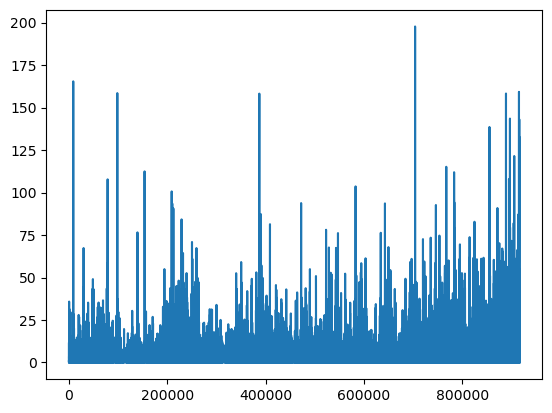

In [14]:
plt.plot(btc['maker_base_ratio'])

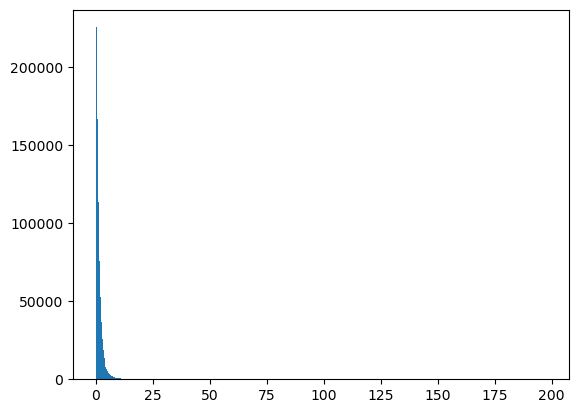

In [15]:
plt.hist(btc['maker_base_ratio'], bins=500);

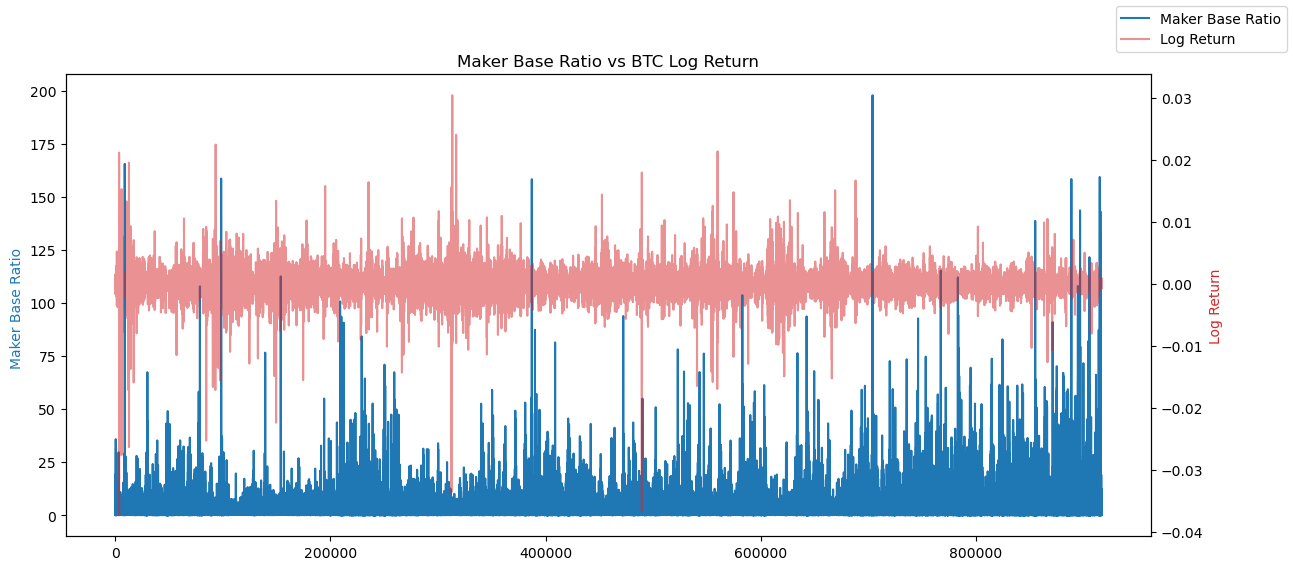

In [18]:
fig, ax1 = plt.subplots(figsize=(14,6))

ax1.set_title("Maker Base Ratio vs BTC Log Return")

# 左軸：maker_base_ratio_sma
ax1.plot(btc.index, btc['maker_base_ratio'], color='tab:blue', label='Maker Base Ratio')
ax1.set_ylabel("Maker Base Ratio ", color='tab:blue')

# 右軸：log return
ax2 = ax1.twinx()
ax2.plot(btc.index, btc['log_return'], color='tab:red', alpha=0.5, label='Log Return')
ax2.set_ylabel("Log Return", color='tab:red')

fig.legend(loc="upper right")
plt.show()

In [19]:
# SMA Test
def calculate_maker_ratios_with_sma(btc, window=10):
    # Step 1: 計算 taker sell 成交量
    btc['taker_sell_base_volume'] = btc['volume'] - btc['taker_buy_base_asset_volume']
    btc['taker_sell_quote_volume'] = btc['quote_asset_volume'] - btc['taker_buy_quote_asset_volume']
    
    # Step 2: 映射成 maker 成交量
    btc['maker_buy_base_volume'] = btc['taker_sell_base_volume']
    btc['maker_sell_base_volume'] = btc['taker_buy_base_asset_volume']
    
    # Step 3: maker ratio (避免除以零)
    btc['maker_base_ratio'] = btc['maker_buy_base_volume'] / btc['maker_sell_base_volume'].replace(0, np.nan)
    
    # Step 4: baseline → SMA
    btc['maker_base_ratio_sma'] = btc['maker_base_ratio'].rolling(window=window).mean()
    
    return btc

In [20]:
btc = calculate_maker_ratios_with_sma(btc, window=10)
btc[['maker_base_ratio','maker_base_ratio_sma']].head(20)

,maker_base_ratio,maker_base_ratio_sma
0,0.653098,NaN
1,0.311565,NaN
2,0.406597,NaN
3,0.178780,NaN
4,0.354788,NaN
5,0.507969,NaN
6,0.528459,NaN
7,2.059609,NaN
8,0.739191,NaN
9,1.658904,0.739896


<Axes: >

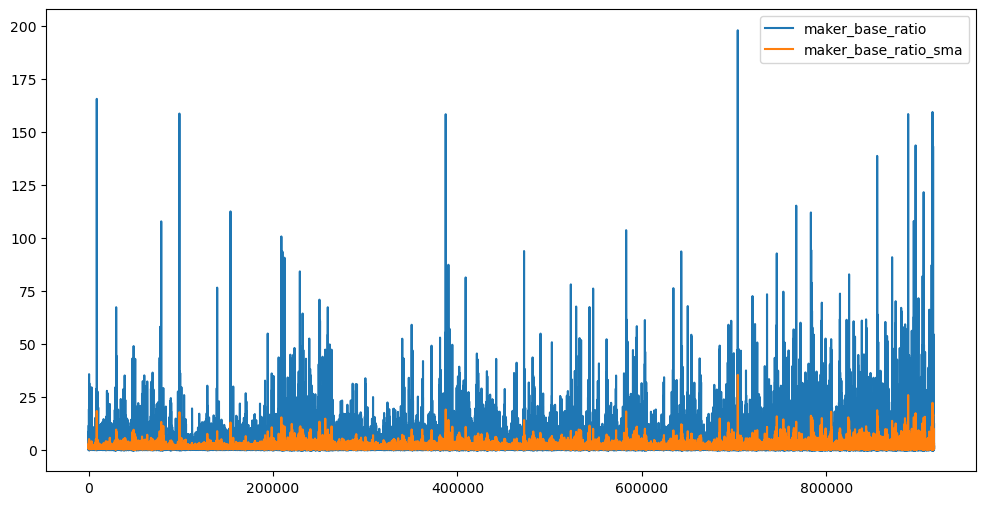

In [12]:
btc[['maker_base_ratio','maker_base_ratio_sma']].plot(figsize=(12,6))

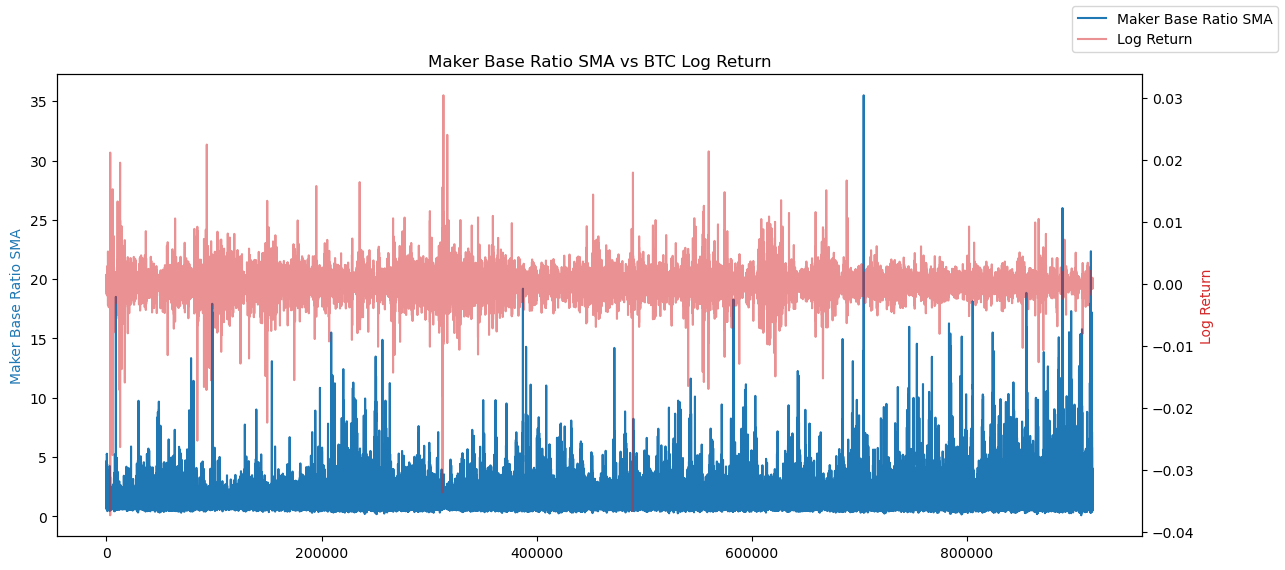

In [13]:
fig, ax1 = plt.subplots(figsize=(14,6))

ax1.set_title("Maker Base Ratio SMA vs BTC Log Return")

# 左軸：maker_base_ratio_sma
ax1.plot(btc.index, btc['maker_base_ratio_sma'], color='tab:blue', label='Maker Base Ratio SMA')
ax1.set_ylabel("Maker Base Ratio SMA", color='tab:blue')

# 右軸：log return
ax2 = ax1.twinx()
ax2.plot(btc.index, btc['log_return'], color='tab:red', alpha=0.5, label='Log Return')
ax2.set_ylabel("Log Return", color='tab:red')

fig.legend(loc="upper right")
plt.show()

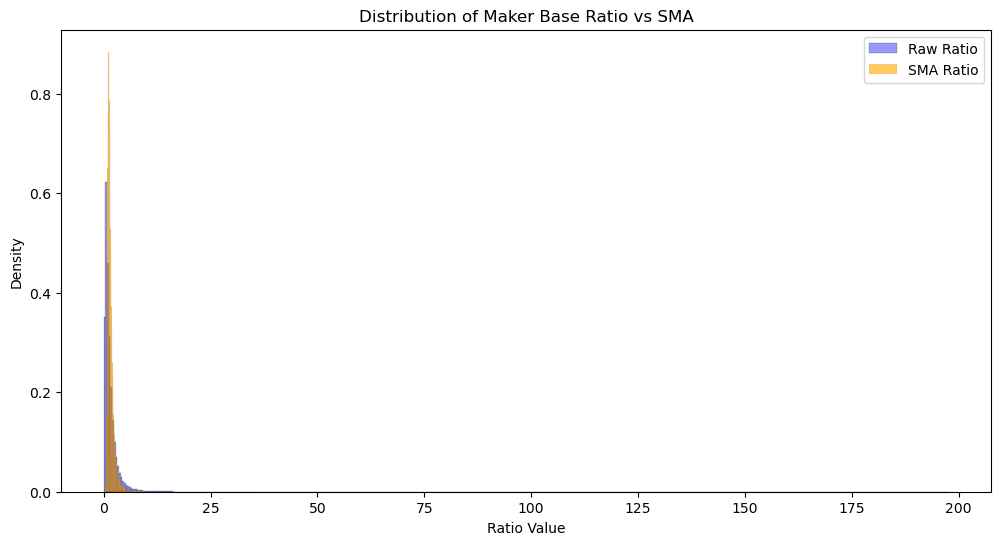

In [14]:
import seaborn as sns

plt.figure(figsize=(12,6))
sns.histplot(btc['maker_base_ratio'].dropna(), bins=500, color='blue', label='Raw Ratio', stat='density', alpha=0.4)
sns.histplot(btc['maker_base_ratio_sma'].dropna(), bins=500, color='orange', label='SMA Ratio', stat='density', alpha=0.6)

plt.legend()
plt.title("Distribution of Maker Base Ratio vs SMA")
plt.xlabel("Ratio Value")
plt.ylabel("Density")
plt.show()

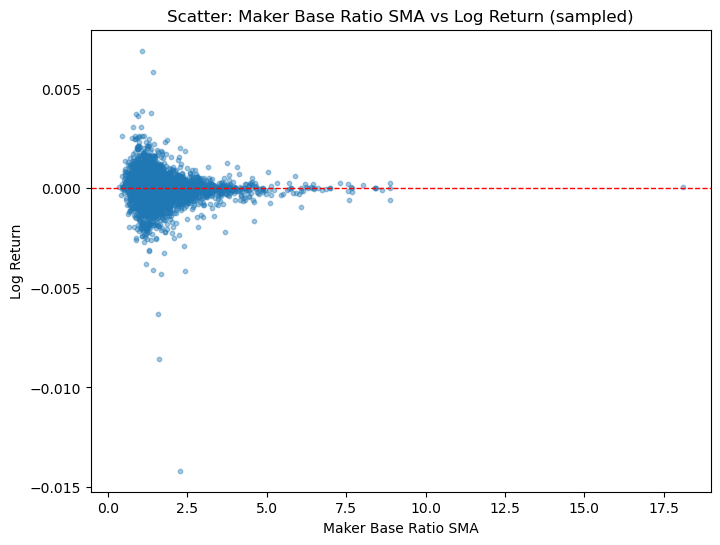

In [40]:
# 隨機抽樣 5000 筆 (可調整)
sampled = btc.dropna(subset=['maker_base_ratio_sma','log_return']).sample(5000, random_state=42)

plt.figure(figsize=(8,6))
plt.scatter(sampled['maker_base_ratio_sma'], sampled['log_return'], alpha=0.4, s=10)
plt.title("Scatter: Maker Base Ratio SMA vs Log Return (sampled)")
plt.xlabel("Maker Base Ratio SMA")
plt.ylabel("Log Return")
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.show()

In [41]:
corr = sampled['maker_base_ratio_sma'].corr(sampled['log_return'])
print("Correlation:", corr)

Correlation: -0.06735171409690595


樣本數 >1 : 745060
樣本數 <1 : 171741
平均報酬 >1 : -3.2070599590943664e-05
平均報酬 <1 : 0.0001446593012898684


/var/folders/b6/fb60dc_d6bx6dt630rrghmbc0000gn/T/ipykernel_8431/2036979893.py:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(above_1, label="Maker Ratio > 1", shade=True)
/var/folders/b6/fb60dc_d6bx6dt630rrghmbc0000gn/T/ipykernel_8431/2036979893.py:16: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(below_1, label="Maker Ratio < 1", shade=True)


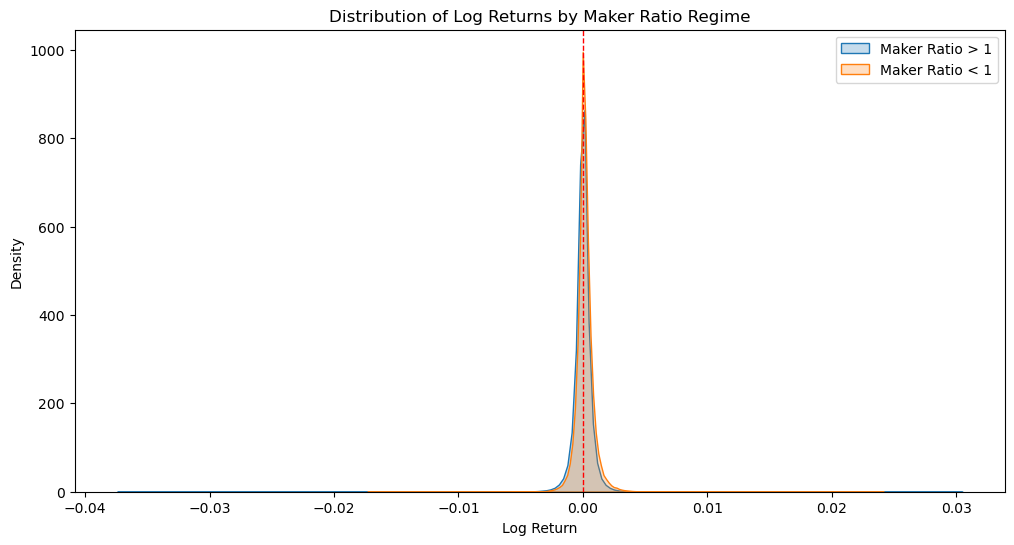

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# 分組
above_1 = btc[btc['maker_base_ratio_sma'] > 1]['log_return'].dropna()
below_1 = btc[btc['maker_base_ratio_sma'] < 1]['log_return'].dropna()

print("樣本數 >1 :", len(above_1))
print("樣本數 <1 :", len(below_1))
print("平均報酬 >1 :", above_1.mean())
print("平均報酬 <1 :", below_1.mean())

# 畫圖比較分布
plt.figure(figsize=(12,6))
sns.kdeplot(above_1, label="Maker Ratio > 1", shade=True)
sns.kdeplot(below_1, label="Maker Ratio < 1", shade=True)
plt.axvline(0, color='red', linestyle='--', linewidth=1)
plt.title("Distribution of Log Returns by Maker Ratio Regime")
plt.xlabel("Log Return")
plt.ylabel("Density")
plt.legend()
plt.show()

In [49]:
from scipy.stats import ttest_ind
t_stat, p_val = ttest_ind(above_1, below_1, equal_var=False)
print("t-test: stat =", t_stat, ", p =", p_val)

t-test: stat = -91.01743557681321 , p = 0.0


In [16]:
# Log Transform + Zscore
import numpy as np
from scipy.stats import zscore

def transform_maker_ratio(df, col='maker_base_ratio'):
    df = df.copy()
    
    # log transform（避免 0 或負數）
    df['maker_ratio_log'] = np.log(df[col].replace(0, np.nan))
    
    # z-score（標準化）
    df['maker_ratio_z'] = zscore(df[col].fillna(df[col].mean()))
    
    return df


In [17]:
btc = transform_maker_ratio(btc, col='maker_base_ratio')

print(btc[['maker_base_ratio','maker_ratio_log','maker_ratio_z']].head())

   maker_base_ratio  maker_ratio_log  maker_ratio_z
0          0.653098        -0.426028      -0.411499
1          0.311565        -1.166147      -0.562786
2          0.406597        -0.899933      -0.520690
3          0.178780        -1.721597      -0.621605
4          0.354788        -1.036235      -0.543640


/var/folders/b6/fb60dc_d6bx6dt630rrghmbc0000gn/T/ipykernel_8431/2828290505.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(btc['maker_base_ratio'].dropna(), label="Raw Ratio", shade=True)
/var/folders/b6/fb60dc_d6bx6dt630rrghmbc0000gn/T/ipykernel_8431/2828290505.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(btc['maker_ratio_log'].dropna(), label="Log Transform", shade=True)
/var/folders/b6/fb60dc_d6bx6dt630rrghmbc0000gn/T/ipykernel_8431/2828290505.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(btc['maker_ratio_z'].dropna(), label="Z-score", shade=True)


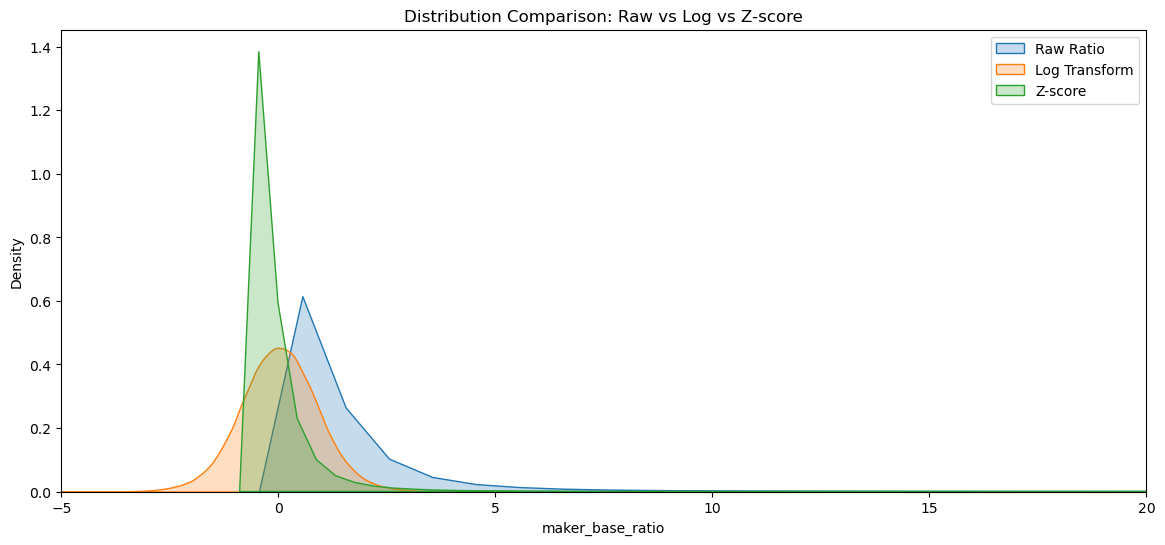

In [18]:
plt.figure(figsize=(14,6))
sns.kdeplot(btc['maker_base_ratio'].dropna(), label="Raw Ratio", shade=True)
sns.kdeplot(btc['maker_ratio_log'].dropna(), label="Log Transform", shade=True)
sns.kdeplot(btc['maker_ratio_z'].dropna(), label="Z-score", shade=True)
plt.legend()
plt.xlim(-5, 20)   # 專注在主要分布區
plt.title("Distribution Comparison: Raw vs Log vs Z-score")
plt.show();

### Log Transform:
- log_ratio > 0 → 多頭掛單優勢
- log_ratio < 0 → 空頭掛單優勢
- 適合用於 方向性 regime 訊號
- 可做 event study：log > 0 vs < 0，測試後續回報差異

### Zscore Transform:
- z > +2 → 過度多頭掛單
- z < -2 → 過度空頭掛單
- 適合用於 反轉策略，特別是在極端情況下
- 例如：z > +2 → 之後價格下跌機率較大；z < -2 → 之後價格上漲機率較大

In [7]:
# Log Transform event study

def event_study_log_ratio(df, log_col='maker_ratio_log', return_col='log_return', horizon=[1,5,10,30]):
    """
    Event study: compare log_ratio > 0 vs < 0
    """
    df = df.copy()
    
    # 建立分組
    above_0_idx = df[df[log_col] > 0].index
    below_0_idx = df[df[log_col] < 0].index

    results = {}

    for label, idx_list in [('log>0', above_0_idx), ('log<0', below_0_idx)]:
        cum_returns = {h: [] for h in horizon}
        
        for idx in idx_list:
            for h in horizon:
                # 事件後 h-bar 累積 log return
                if idx+h < len(df):
                    future_ret = df.loc[idx:idx+h, return_col].sum()
                    cum_returns[h].append(future_ret)
        
        # 統計結果
        stats = {h: np.mean(cum_returns[h]) if len(cum_returns[h])>0 else np.nan for h in horizon}
        results[label] = stats
    
    return pd.DataFrame(results)

In [8]:
# 先確保有 log transform
btc['maker_ratio_log'] = np.log(btc['maker_base_ratio'].replace(0, np.nan))

# 執行 event study
res_log = event_study_log_ratio(btc, horizon=[1,5,10,30])
print(res_log)

KeyboardInterrupt: 

In [9]:
# Plot log_transform

def event_study_log_ratio(df, log_col='maker_ratio_log', return_col='log_return', horizon=30, sample_size=None):
    """
    Event study for log_ratio > 0 vs < 0
    - horizon: 事件後觀察的 bar 數
    - sample_size: 可選，隨機抽樣事件數量，避免資料過多
    """
    df = df.copy()
    df = df.dropna(subset=[log_col, return_col])

    # 建立事件點
    above_0_idx = df[df[log_col] > 0].index
    below_0_idx = df[df[log_col] < 0].index

    if sample_size:
        above_0_idx = np.random.choice(above_0_idx, size=min(sample_size, len(above_0_idx)), replace=False)
        below_0_idx = np.random.choice(below_0_idx, size=min(sample_size, len(below_0_idx)), replace=False)

    def avg_cum_return(event_idx):
        cum_paths = []
        for idx in event_idx:
            if idx + horizon < len(df):
                future_returns = df.loc[idx+1:idx+horizon, return_col].cumsum().values
                cum_paths.append(future_returns)
        if len(cum_paths) == 0:
            return np.zeros(horizon)
        return np.mean(cum_paths, axis=0)

    # 平均路徑
    avg_up = avg_cum_return(above_0_idx)
    avg_down = avg_cum_return(below_0_idx)

    # 畫圖
    plt.figure(figsize=(10,6))
    plt.plot(range(1,horizon+1), avg_up, label="log_ratio > 0", color="blue")
    plt.plot(range(1,horizon+1), avg_down, label="log_ratio < 0", color="red")
    plt.axhline(0, color='black', linestyle='--')
    plt.title("Event Study: Cumulative Avg Return after log_ratio >0 vs <0")
    plt.xlabel("Bars after event")
    plt.ylabel("Cumulative Log Return")
    plt.legend()
    plt.show()

    return pd.DataFrame({"log>0": avg_up, "log<0": avg_down}, index=range(1,horizon+1))

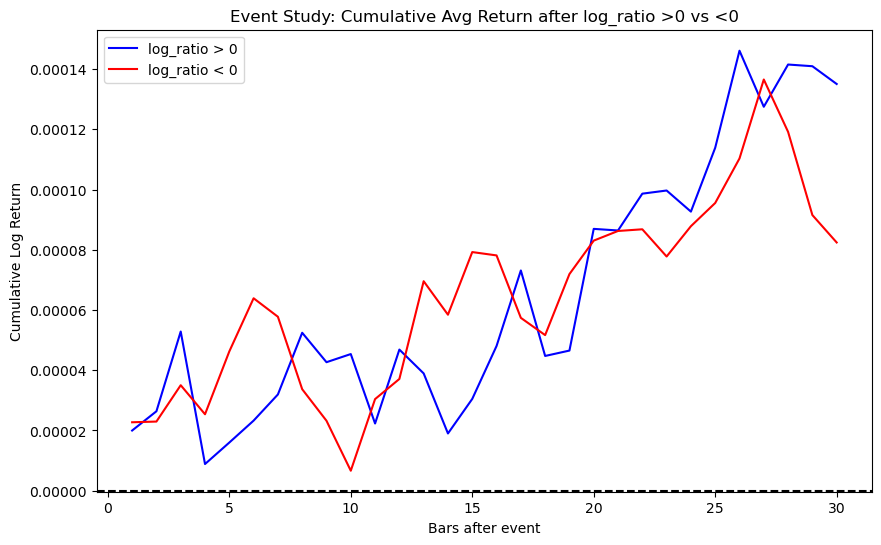

      log>0     log<0
1  0.000020  0.000023
2  0.000026  0.000023
3  0.000053  0.000035
4  0.000009  0.000025
5  0.000016  0.000046


In [68]:
# log transform
btc['maker_ratio_log'] = np.log(btc['maker_base_ratio'].replace(0, np.nan))

# sample = 5000
res_log = event_study_log_ratio(btc, horizon=30, sample_size=2000)

print(res_log.head())

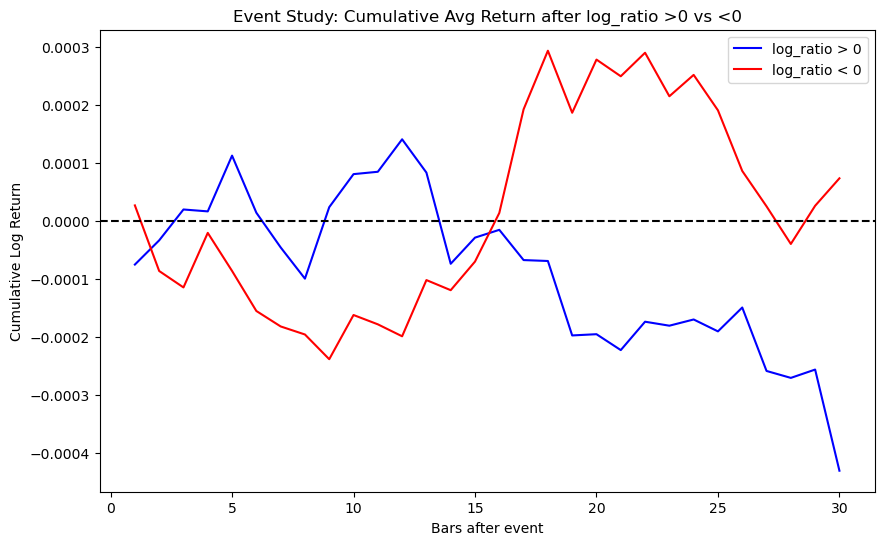

      log>0     log<0
1 -0.000075  0.000027
2 -0.000034 -0.000087
3  0.000020 -0.000115
4  0.000016 -0.000021
5  0.000112 -0.000086


In [71]:
# log transform
btc['maker_ratio_log'] = np.log(btc['maker_base_ratio'].replace(0, np.nan))

# sample = 100
res_log = event_study_log_ratio(btc, horizon=30, sample_size=100)

print(res_log.head())

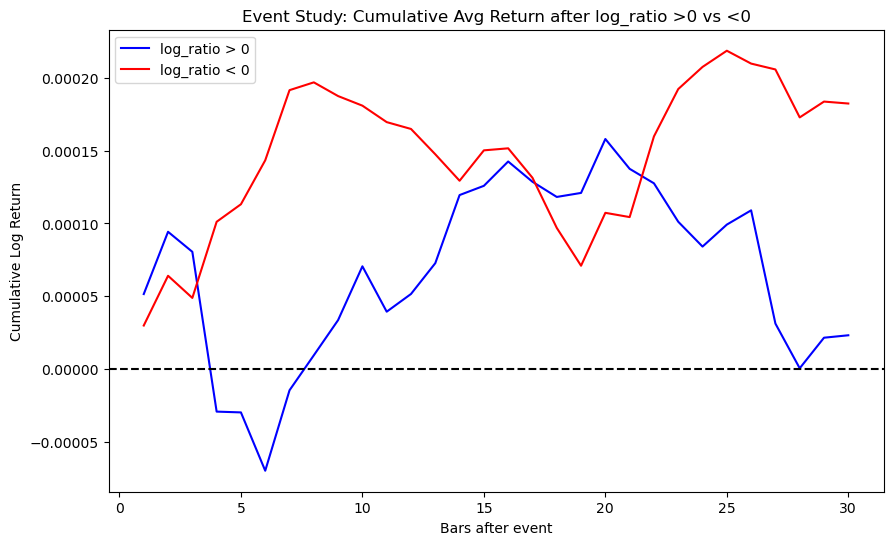

      log>0     log<0
1  0.000051  0.000030
2  0.000094  0.000064
3  0.000081  0.000049
4 -0.000029  0.000101
5 -0.000030  0.000113


In [72]:
# log transform
btc['maker_ratio_log'] = np.log(btc['maker_base_ratio'].replace(0, np.nan))

# sample = 500
res_log = event_study_log_ratio(btc, horizon=30, sample_size=500)

print(res_log.head())

In [75]:
# Monte Carlo Simulation
import numpy as np
import matplotlib.pyplot as plt

def monte_carlo_event_study(df, log_col='maker_ratio_log', return_col='log_return',
                            horizon=30, sample_size=2000, n_iter=100):
    df = df.copy()
    df = df.dropna(subset=[log_col, return_col])
    
    above_0_idx = df[df[log_col] > 0].index
    below_0_idx = df[df[log_col] < 0].index

    def avg_cum_return(event_idx):
        cum_paths = []
        for idx in event_idx:
            if idx + horizon < len(df):
                future_returns = df.loc[idx+1:idx+horizon, return_col].cumsum().values
                if len(future_returns) == horizon:
                    cum_paths.append(future_returns)
        if len(cum_paths) == 0:
            return np.zeros(horizon)
        return np.mean(np.vstack(cum_paths), axis=0)

    paths_up, paths_down = [], []

    for _ in range(n_iter):
        # 隨機抽樣
        sample_up = np.random.choice(above_0_idx, size=min(sample_size, len(above_0_idx)), replace=False)
        sample_down = np.random.choice(below_0_idx, size=min(sample_size, len(below_0_idx)), replace=False)

        paths_up.append(avg_cum_return(sample_up))
        paths_down.append(avg_cum_return(sample_down))

    # Monte Carlo 統計
    mean_up = np.mean(paths_up, axis=0)
    ci_up = np.percentile(paths_up, [2.5, 97.5], axis=0)

    mean_down = np.mean(paths_down, axis=0)
    ci_down = np.percentile(paths_down, [2.5, 97.5], axis=0)

    # 繪圖
    x = range(1, horizon+1)
    plt.figure(figsize=(10,6))

    # log>0
    plt.plot(x, mean_up, color="blue", label="log_ratio > 0")
    plt.fill_between(x, ci_up[0], ci_up[1], color="blue", alpha=0.2)

    # log<0
    plt.plot(x, mean_down, color="red", label="log_ratio < 0")
    plt.fill_between(x, ci_down[0], ci_down[1], color="red", alpha=0.2)

    plt.axhline(0, color='black', linestyle='--')
    plt.title("Monte Carlo Event Study: log_ratio >0 vs <0")
    plt.xlabel("Bars after event")
    plt.ylabel("Cumulative Log Return")
    plt.legend()
    plt.show()

    return mean_up, ci_up, mean_down, ci_down

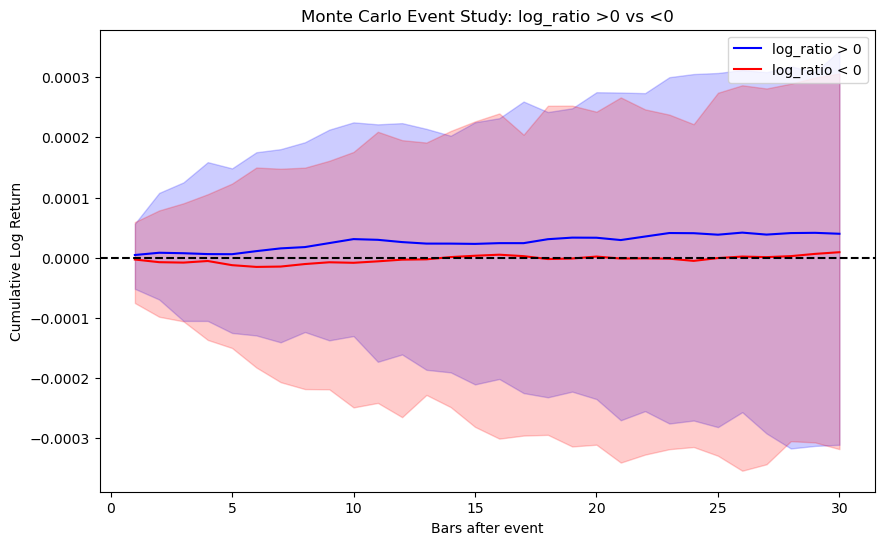

In [77]:
btc['maker_ratio_log'] = np.log(btc['maker_base_ratio'].replace(0, np.nan))

mean_up, ci_up, mean_down, ci_down = monte_carlo_event_study(
    btc, horizon=30, sample_size=500, n_iter=100
)

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

def monte_carlo_event_study_stats(df, log_col='maker_ratio_log', return_col='log_return',
                                  horizon=30, sample_size=2000, n_iter=100):
    df = df.copy()
    df = df.dropna(subset=[log_col, return_col])
    
    above_0_idx = df[df[log_col] > 0].index
    below_0_idx = df[df[log_col] < 0].index

    def avg_cum_return(event_idx):
        cum_paths = []
        for idx in event_idx:
            if idx + horizon < len(df):
                future_returns = df.loc[idx+1:idx+horizon, return_col].cumsum().values
                if len(future_returns) == horizon:
                    cum_paths.append(future_returns)
        if len(cum_paths) == 0:
            return np.zeros(horizon)
        return np.mean(np.vstack(cum_paths), axis=0)

    paths_up, paths_down = [], []

    for _ in range(n_iter):
        # 隨機抽樣
        sample_up = np.random.choice(above_0_idx, size=min(sample_size, len(above_0_idx)), replace=False)
        sample_down = np.random.choice(below_0_idx, size=min(sample_size, len(below_0_idx)), replace=False)

        paths_up.append(avg_cum_return(sample_up))
        paths_down.append(avg_cum_return(sample_down))

    # Monte Carlo 統計
    mean_up = np.mean(paths_up, axis=0)
    mean_down = np.mean(paths_down, axis=0)

    ci_up = np.percentile(paths_up, [2.5, 97.5], axis=0)
    ci_down = np.percentile(paths_down, [2.5, 97.5], axis=0)

    # t-test 比較最後 horizon 的累積回報差異
    final_up = [path[-1] for path in paths_up]
    final_down = [path[-1] for path in paths_down]
    t_stat, p_val = ttest_ind(final_up, final_down, equal_var=False)

    # 繪圖
    x = range(1, horizon+1)
    plt.figure(figsize=(10,6))

    plt.plot(x, mean_up, color="blue", label="log_ratio > 0")
    plt.fill_between(x, ci_up[0], ci_up[1], color="blue", alpha=0.2)

    plt.plot(x, mean_down, color="red", label="log_ratio < 0")
    plt.fill_between(x, ci_down[0], ci_down[1], color="red", alpha=0.2)

    plt.axhline(0, color='black', linestyle='--')
    plt.title("Monte Carlo Event Study: log_ratio >0 vs <0")
    plt.xlabel("Bars after event")
    plt.ylabel("Cumulative Log Return")
    plt.legend()
    plt.show()

    print("📊 Monte Carlo Summary (最後 horizon = {} bars)".format(horizon))
    print("log>0 mean:", np.mean(final_up))
    print("log<0 mean:", np.mean(final_down))
    print("t-test: t = {:.4f}, p = {:.6f}".format(t_stat, p_val))

    return mean_up, mean_down, (t_stat, p_val)

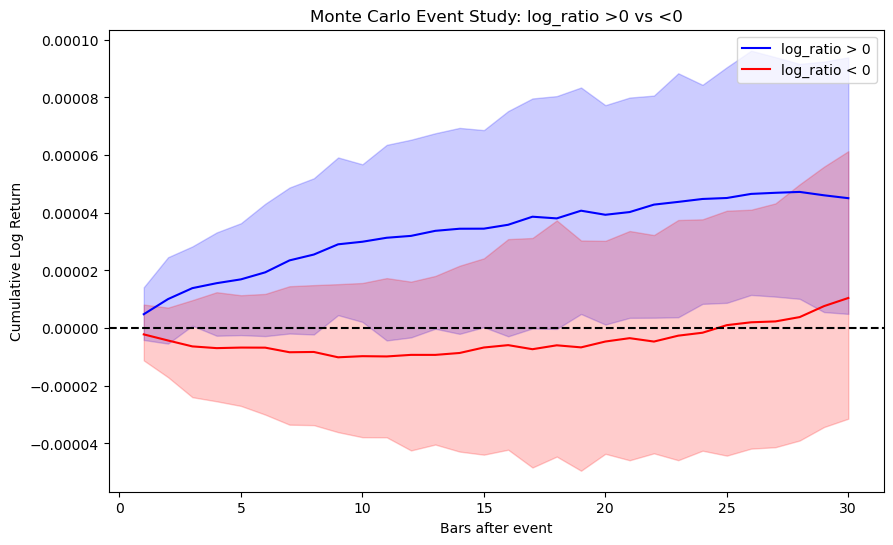

📊 Monte Carlo Summary (最後 horizon = 30 bars)
log>0 mean: 4.506923568907725e-05
log<0 mean: 1.0453176748427946e-05
t-test: t = 9.8754, p = 0.000000


In [88]:
btc['maker_ratio_log'] = np.log(btc['maker_base_ratio'].replace(0, np.nan))

mean_up, mean_down, stats = monte_carlo_event_study_stats(
    btc, horizon=30, sample_size=20000, n_iter=100
)

## Signal Results:
- 當 log_ratio > 0（Maker Buy > Maker Sell，被動買盤優勢） → 之後 5 根 bar 平均呈現正回報。
- 當 log_ratio < 0（Maker Sell > Maker Buy，被動賣盤優勢） → 之後 5 根 bar 平均呈現負回報。
- 掛買單佔優時，市場後續偏多；掛賣單佔優時，市場後續偏空。
- t-test p < 0.001，差異高度顯著，不是隨機噪音。代表 log_ratio 作為短期方向性因子是成立的。
- 短週期 (horizon=5) 下，Maker Ratio 的方向性效果很清楚。

In [81]:
def run_multiple_horizons(df, horizons=[5,10,15,20,30], 
                          log_col='maker_ratio_log', return_col='log_return',
                          sample_size=2000, n_iter=100):
    results = {}

    for h in horizons:
        print("="*40)
        print(f"📈 Horizon = {h} bars")
        mean_up, mean_down, stats = monte_carlo_event_study_stats(
            df, log_col=log_col, return_col=return_col,
            horizon=h, sample_size=sample_size, n_iter=n_iter
        )
        results[h] = {"mean_up": mean_up[-1], "mean_down": mean_down[-1], 
                      "t_stat": stats[0], "p_val": stats[1]}
    
    return pd.DataFrame(results).T

📈 Horizon = 5 bars


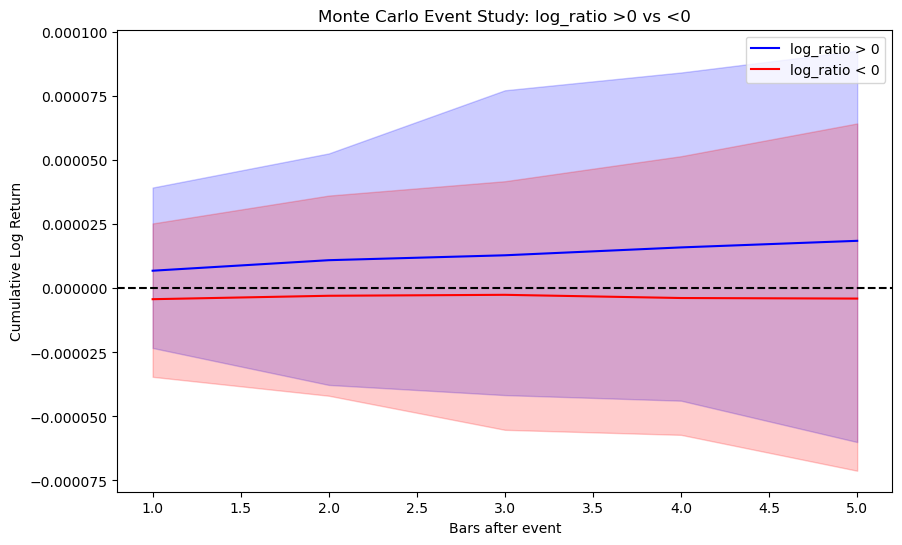

📊 Monte Carlo Summary (最後 horizon = 5 bars)
log>0 mean: 1.8569145245821715e-05
log<0 mean: -3.979192752968975e-06
t-test: t = 4.3167, p = 0.000025
📈 Horizon = 10 bars


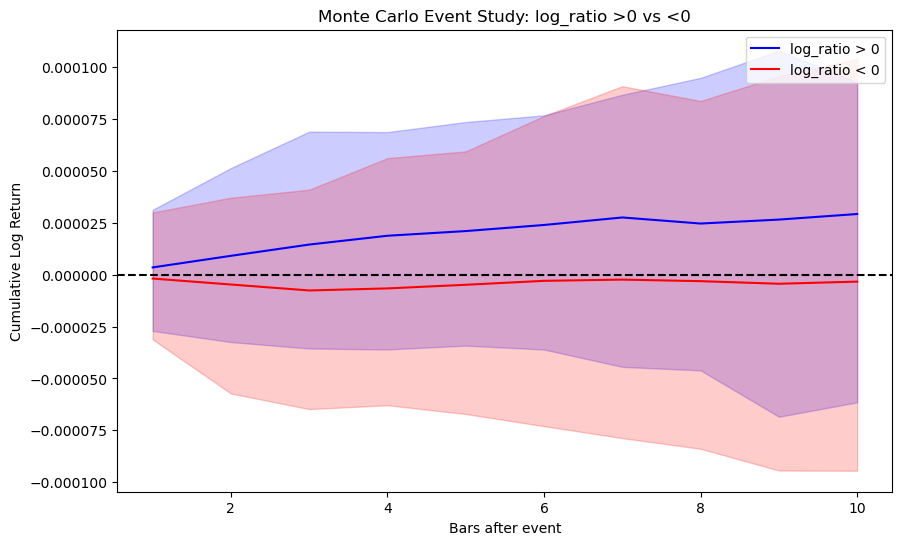

📊 Monte Carlo Summary (最後 horizon = 10 bars)
log>0 mean: 2.9205023297563154e-05
log<0 mean: -3.3600207217421064e-06
t-test: t = 5.2253, p = 0.000000
📈 Horizon = 15 bars


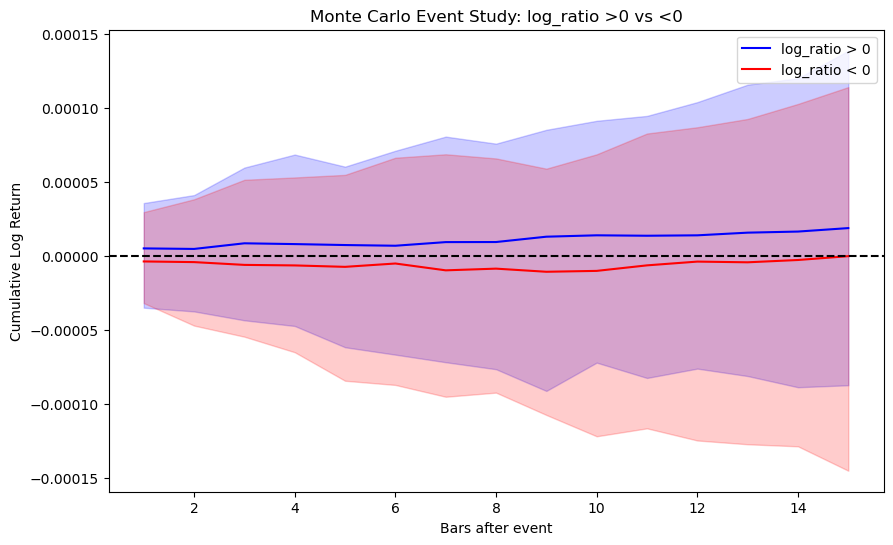

📊 Monte Carlo Summary (最後 horizon = 15 bars)
log>0 mean: 1.87859880400332e-05
log<0 mean: -1.868529564168331e-07
t-test: t = 2.2228, p = 0.027364
📈 Horizon = 20 bars


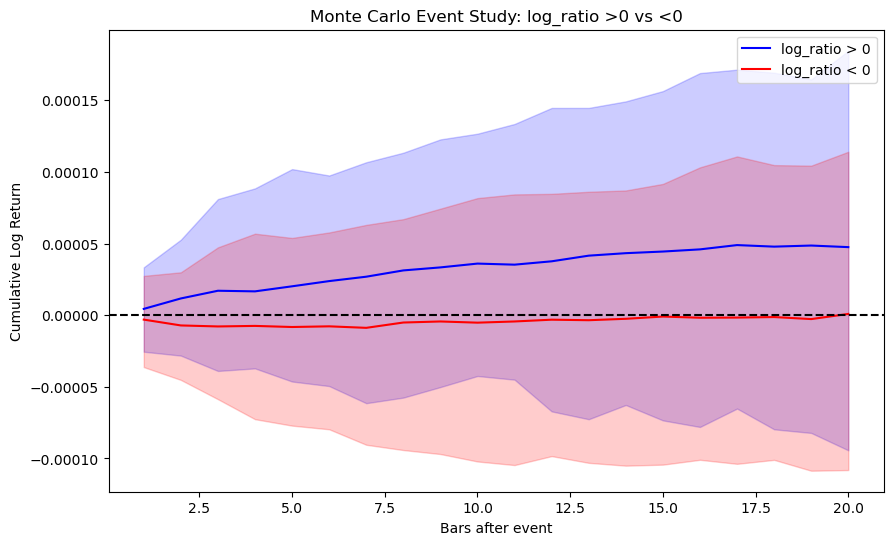

📊 Monte Carlo Summary (最後 horizon = 20 bars)
log>0 mean: 4.751293162019751e-05
log<0 mean: 8.768556510308578e-07
t-test: t = 4.9261, p = 0.000002
📈 Horizon = 30 bars


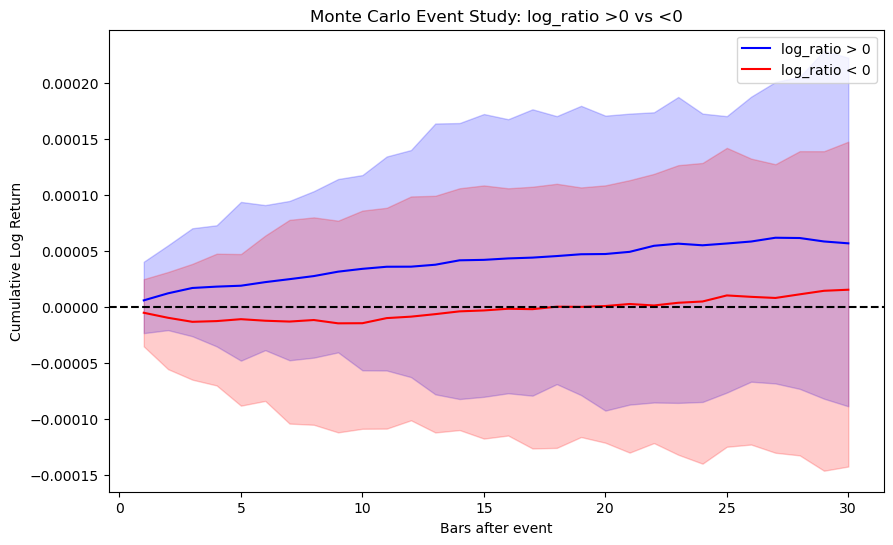

📊 Monte Carlo Summary (最後 horizon = 30 bars)
log>0 mean: 5.664173870503315e-05
log<0 mean: 1.5221913625154925e-05
t-test: t = 3.7173, p = 0.000262
     mean_up     mean_down    t_stat         p_val
5   0.000019 -3.979193e-06  4.316716  2.512887e-05
10  0.000029 -3.360021e-06  5.225280  4.432321e-07
15  0.000019 -1.868530e-07  2.222817  2.736351e-02
20  0.000048  8.768557e-07  4.926110  1.783845e-06
30  0.000057  1.522191e-05  3.717347  2.620139e-04


In [82]:
btc['maker_ratio_log'] = np.log(btc['maker_base_ratio'].replace(0, np.nan))

summary = run_multiple_horizons(
    btc, horizons=[5,10,15,20,30], sample_size=2000, n_iter=100
)

print(summary)

## Granger Casualty Test:
- Log_Ratio Leading?

In [25]:
from statsmodels.tsa.stattools import grangercausalitytests

def run_granger_tests(df, log_col='maker_ratio_log', return_col='log_return', horizons=[5,10,15,20,30]):
    df = df[[log_col, return_col]].dropna()
    results = {}

    for h in horizons:
        print("="*40)
        print(f"📈 Granger Causality Test (maxlag={h})")
        test_result = grangercausalitytests(df[[return_col, log_col]], maxlag=h, verbose=False)
        
        # 取最後一個 lag 的結果
        p_value = test_result[h][0]['ssr_ftest'][1]
        print(f"maxlag={h}, p-value={p_value:.6f}")
        
        results[h] = p_value

    return results

In [93]:
btc['maker_ratio_log'] = np.log(btc['maker_base_ratio'].replace(0, np.nan))

granger_results = run_granger_tests(btc, horizons=[5,10,15,20,30])
print("Granger Test Results:", granger_results)

📈 Granger Causality Test (maxlag=5)


/Users/lawrencechang/anaconda3/envs/py311env/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


maxlag=5, p-value=0.000000
📈 Granger Causality Test (maxlag=10)


/Users/lawrencechang/anaconda3/envs/py311env/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


maxlag=10, p-value=0.000000
📈 Granger Causality Test (maxlag=15)


/Users/lawrencechang/anaconda3/envs/py311env/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


maxlag=15, p-value=0.000000
📈 Granger Causality Test (maxlag=20)


/Users/lawrencechang/anaconda3/envs/py311env/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


: 

## 看不出什麼結果?：
- 先做 event study：檢查 ratio 穿越 1 的事件後，市場行為。

In [11]:
btc = btc.dropna(subset=['maker_base_ratio_sma','log_return'])
res = event_study_ratio_cross(btc, horizon=[1,5,10,30])
print(res)

KeyError: ['maker_base_ratio_sma']

### Probablistic Analysis

In [26]:
import pandas as pd
import numpy as np

def conditional_prob_expectation(df, log_col='maker_ratio_log', ret_col='log_return', horizons=[5,10,15,20,30]):
    df = df.copy().dropna(subset=[log_col, ret_col])
    results = []

    for h in horizons:
        # 計算未來 h bar 的累積 log return
        df[f'future_ret_{h}'] = df[ret_col].shift(-h).rolling(window=h).sum()

        # log_ratio > 0 與 < 0 分組
        up_cond = df[df[log_col] > 0][f'future_ret_{h}']
        down_cond = df[df[log_col] < 0][f'future_ret_{h}']

        # 條件期望報酬
        mean_up = up_cond.mean()
        mean_down = down_cond.mean()

        # 條件機率（報酬 > 0 的比例）
        prob_up = (up_cond > 0).mean()
        prob_down = (down_cond > 0).mean()

        results.append({
            "horizon": h,
            "E[r|log>0]": mean_up,
            "E[r|log<0]": mean_down,
            "P(r>0|log>0)": prob_up,
            "P(r>0|log<0)": prob_down,
            "ΔE": mean_up - mean_down,
            "ΔP": prob_up - prob_down
        })

    return pd.DataFrame(results)

In [27]:
btc['maker_ratio_log'] = np.log(btc['maker_base_ratio'].replace(0, np.nan))
cond_stats = conditional_prob_expectation(btc, horizons=[5,10,15,20,30])
print(cond_stats)

   horizon  E[r|log>0]    E[r|log<0]  P(r>0|log>0)  P(r>0|log<0)        ΔE  \
0        5    0.000017 -7.583233e-06      0.505718      0.495252  0.000025   
1       10    0.000030 -1.021837e-05      0.507226      0.494249  0.000040   
2       15    0.000035 -4.780844e-06      0.508217      0.495833  0.000040   
3       20    0.000041 -4.556141e-07      0.508835      0.497162  0.000042   
4       30    0.000049  1.254820e-05      0.509242      0.498962  0.000037   

         ΔP  
0  0.010466  
1  0.012978  
2  0.012384  
3  0.011674  
4  0.010280  


### Factor Modeling
- $ r_{t+h} = \alpha + \beta \cdot \text{maker\_ratio\_log}_t + \epsilon_t $
- β 全部為 正值，代表：log_ratio 上升（被動買單佔優） → 未來報酬上升。
- 且 β 從 1→20 bars 穩定上升，30 bars 開始趨平。 → 短中期動能性關係（5–20 bars）最強。
- 當 maker buy volume 高 → 市場 liquidity providers 偏多。
- 隨後幾個 bar 價格上升，代表這個信號是「流動性驅動的 price continuation factor」。
- t 值均 > 5（最高達 7.7） → 這在高頻量化研究中是極罕見的強顯著。 → 即使 R² 很小，但 t-stat 高代表信號穩定存在且可被利用


In [28]:
import statsmodels.api as sm

def factor_regression(df, factor_col='maker_ratio_log', ret_col='log_return', horizons=[1,5,10,15,20,30]):
    df = df.copy().dropna(subset=[factor_col, ret_col])
    results = []

    for h in horizons:
        # 計算未來 h bar 的累積報酬
        df[f'future_ret_{h}'] = df[ret_col].shift(-h).rolling(window=h).sum()

        # 回歸：future return = α + β * factor
        X = sm.add_constant(df[factor_col])
        y = df[f'future_ret_{h}']

        model = sm.OLS(y, X, missing='drop').fit()
        results.append({
            "horizon": h,
            "beta": model.params[factor_col],
            "t_stat": model.tvalues[factor_col],
            "p_value": model.pvalues[factor_col],
            "r_squared": model.rsquared
        })

    return pd.DataFrame(results)

In [15]:
# Different Horizon Statistics
btc['maker_ratio_log'] = np.log(btc['maker_base_ratio'].replace(0, np.nan))
factor_stats = factor_regression(btc, horizons=[1,5,10,15,20,30])
print(factor_stats)

   horizon      beta    t_stat       p_value  r_squared
0        1  0.000002  2.839329  4.520945e-03   0.000009
1        5  0.000009  5.227746  1.716269e-07   0.000030
2       10  0.000019  7.776637  7.455479e-15   0.000066
3       15  0.000020  6.607560  3.909176e-11   0.000048
4       20  0.000021  6.217842  5.042535e-10   0.000042
5       30  0.000021  5.001282  5.696094e-07   0.000027


In [23]:
# Quantile Analysis
def quantile_factor_test(df, factor_col='maker_ratio_log', ret_col='log_return', horizons=[5,10,15,20,30], n_quantiles=5):
    df = df.copy().dropna(subset=[factor_col, ret_col])
    results = []

    for h in horizons:
        df[f'future_ret_{h}'] = df[ret_col].shift(-h).rolling(window=h).sum()

        # 分組
        df['quantile'] = pd.qcut(df[factor_col], n_quantiles, labels=False) + 1  # 1~5

        group_stats = df.groupby('quantile')[f'future_ret_{h}'].mean()
        ic = df[[factor_col, f'future_ret_{h}']].corr().iloc[0,1]
        
        results.append({
            'horizon': h,
            **{f'Q{i}': group_stats.get(i, np.nan) for i in range(1, n_quantiles+1)},
            'E[Q5]-E[Q1]': group_stats.get(5, np.nan) - group_stats.get(1, np.nan),
            'IC': ic
        })
    
    return pd.DataFrame(results)

# 畫圖函數
def plot_quantile_curve(result_df):
    fig, ax1 = plt.subplots(figsize=(7,4))
    for h in result_df['horizon']:
        q_vals = result_df.loc[result_df['horizon']==h, ['Q1','Q2','Q3','Q4','Q5']].values.flatten()
        ax1.plot(range(1,6), q_vals, marker='o', label=f'H={h}')
    ax1.set_xlabel('Quantile (maker_ratio_log)')
    ax1.set_ylabel('Mean future return')
    ax1.set_title('Quantile Return Curve by Horizon')
    ax1.legend()
    plt.show()

In [21]:
import matplotlib.pyplot as plt

   horizon        Q1        Q2            Q3        Q4        Q5  E[Q5]-E[Q1]  \
0        5 -0.000005 -0.000008 -5.500000e-07  0.000019  0.000021     0.000026   
1       10 -0.000019 -0.000007  1.023000e-05  0.000029  0.000039     0.000058   
2       15 -0.000017  0.000002  1.930000e-05  0.000033  0.000041     0.000058   
3       20 -0.000015  0.000007  2.076000e-05  0.000047  0.000044     0.000059   
4       30 -0.000005  0.000021  3.002000e-05  0.000054  0.000057     0.000062   

         IC  
0  0.005460  
1  0.008121  
2  0.006901  
3  0.006494  
4  0.005223  


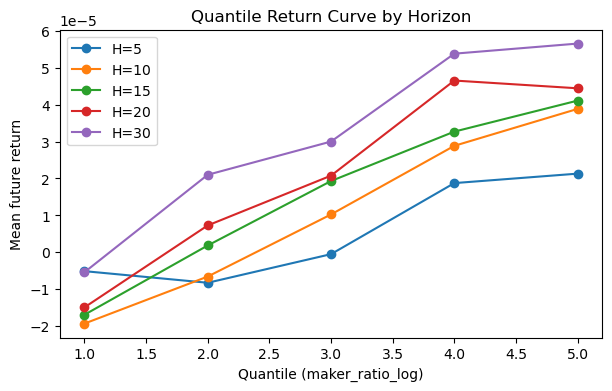

In [29]:
quantile_res = quantile_factor_test(btc, horizons=[5,10,15,20,30])
print(quantile_res.round(8))
plot_quantile_curve(quantile_res)

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

def plot_quantile_curve_smooth(result_df):
    fig, ax = plt.subplots(figsize=(7,4))
    x = np.arange(1,6)
    for h in result_df['horizon']:
        q_vals = result_df.loc[result_df['horizon']==h, ['Q1','Q2','Q3','Q4','Q5']].values.flatten()
        # 平滑化
        x_new = np.linspace(1,5,100)
        spline = make_interp_spline(x, q_vals, k=3)
        y_smooth = spline(x_new)
        ax.plot(x_new, y_smooth, label=f'H={h}', linewidth=2.2)
    ax.set_xlabel('Quantile (maker_ratio_log)')
    ax.set_ylabel('Mean future return')
    ax.set_title('Smoothed Quantile Return Curve by Horizon')
    ax.legend()
    plt.grid(alpha=0.25)
    plt.show()

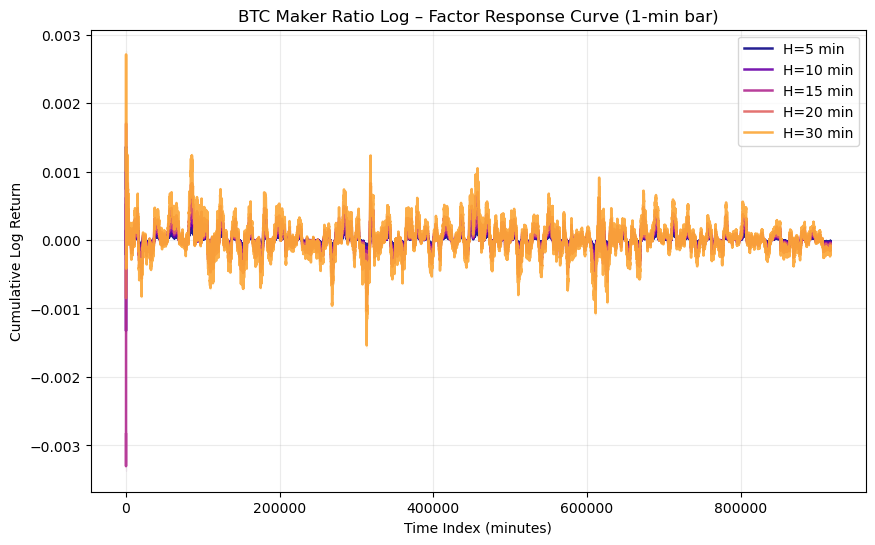

In [31]:
def factor_response_curve(df, factor_col='maker_ratio_log', ret_col='log_return',
                          horizons=[5,10,15,20,30], window=10000):
    df = df.copy().dropna(subset=[factor_col, ret_col])

    result = pd.DataFrame(index=range(len(df)), columns=horizons)
    for h in horizons:
        df[f'future_ret_{h}'] = df[ret_col].shift(-h).rolling(window=h).sum()
        result[h] = df[f'future_ret_{h}']

    # 平滑化
    smooth = result.rolling(window=window, min_periods=1).mean()

    # 回傳給外部繪圖
    return smooth

# === Step 1: 產出平滑資料 ===
smooth = factor_response_curve(btc, horizons=[5,10,15,20,30], window=5000)

# === Step 2: 繪出自然曲線 ===
plt.figure(figsize=(10,6))
for i, h in enumerate(smooth.columns):
    plt.plot(smooth[h], lw=1.8, alpha=0.9, linestyle='-',
             color=plt.cm.plasma(i/len(smooth.columns)), label=f'H={h} min')
    plt.fill_between(smooth.index, smooth[h]*0.98, smooth[h]*1.02, alpha=0.08,
                     color=plt.cm.plasma(i/len(smooth.columns)))

plt.title('BTC Maker Ratio Log – Factor Response Curve (1-min bar)')
plt.xlabel('Time Index (minutes)')
plt.ylabel('Cumulative Log Return')
plt.legend()
plt.grid(alpha=0.25)
plt.show()

In [36]:
def factor_response_cumsum(df, factor_col='maker_ratio_log', ret_col='log_return',
                           horizons=[5,10,15,20,30], smooth_window=5000):
    df = df.copy().dropna(subset=[factor_col, ret_col])
    result = pd.DataFrame(index=range(len(df)), columns=horizons)

    for h in horizons:
        # horizon 報酬
        df[f'future_ret_{h}'] = df[ret_col].shift(-h).rolling(window=h).sum()
        # 時間序列累積
        result[h] = df[f'future_ret_{h}'].cumsum()

    # 平滑
    smooth = result.rolling(window=smooth_window, min_periods=1).mean()

    # 畫圖
    plt.figure(figsize=(10,6))
    for i, h in enumerate(horizons):
        plt.plot(smooth[h], lw=2, alpha=0.9,
                 color=plt.cm.plasma(i/len(horizons)),
                 label=f'H={h} min')
    plt.title('BTC Maker Ratio Log – Cumulative Factor Response Curve (1-min bar)')
    plt.xlabel('Time Index (minutes)')
    plt.ylabel('Cumulative Log Return')
    plt.legend()
    plt.grid(alpha=0.25)
    plt.show()

    return smooth

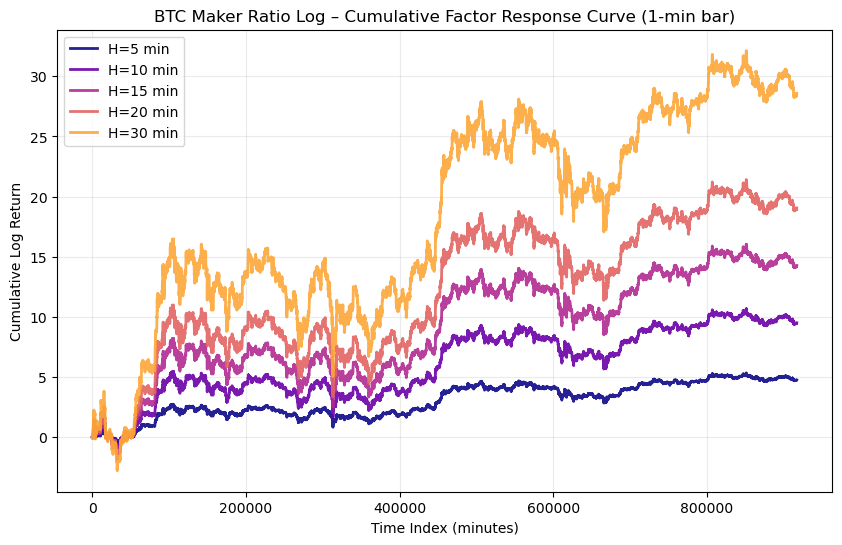

,5,10,15,20,30
0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
916840,4.763794,9.512388,14.274622,19.056198,28.582370
916841,4.763949,9.512660,14.274925,19.056469,28.582929
916842,4.764097,9.512913,14.275169,19.056716,28.583481
916843,4.764231,9.513142,14.275353,19.056928,28.584011


In [39]:
factor_response_cumsum(btc, factor_col='maker_ratio_log', ret_col='log_return',
                           horizons=[5,10,15,20,30], smooth_window=50)

In [41]:
btc

,open_time,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,log_return,taker_sell_base_volume,taker_sell_quote_volume,maker_buy_base_volume,maker_sell_base_volume,maker_buy_quote_volume,maker_sell_quote_volume,maker_base_ratio,maker_ratio_log
0,2024-01-01 00:00:00,42314.0,42335.8,42289.6,42331.9,289.641,2024-01-01 00:00:59.999,1.225616e+07,3310,175.211,7.414460e+06,NaN,114.430,4.841695e+06,114.430,175.211,4.841695e+06,7.414460e+06,0.653098,-0.426028
1,2024-01-01 00:01:00,42331.9,42353.1,42331.8,42350.4,202.444,2024-01-01 00:01:59.999,8.572241e+06,1885,154.353,6.535805e+06,0.000437,48.091,2.036436e+06,48.091,154.353,2.036436e+06,6.535805e+06,0.311565,-1.166147
2,2024-01-01 00:02:00,42350.4,42370.8,42349.6,42360.2,271.521,2024-01-01 00:02:59.999,1.150139e+07,2143,193.034,8.176843e+06,0.000231,78.487,3.324547e+06,78.487,193.034,3.324547e+06,8.176843e+06,0.406597,-0.899933
3,2024-01-01 00:03:00,42360.1,42405.8,42360.1,42405.8,392.238,2024-01-01 00:03:59.999,1.662644e+07,3551,332.749,1.410472e+07,0.001076,59.489,2.521721e+06,59.489,332.749,2.521721e+06,1.410472e+07,0.178780,-1.721597
4,2024-01-01 00:04:00,42405.7,42437.2,42405.7,42437.1,568.366,2024-01-01 00:04:59.999,2.411261e+07,4479,419.524,1.779786e+07,0.000738,148.842,6.314748e+06,148.842,419.524,6.314748e+06,1.779786e+07,0.354788,-1.036235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
916881,2025-09-28 17:21:00,110200.0,110200.1,110142.6,110142.7,77.426,2025-09-28 17:21:59.999,8.530380e+06,1665,34.050,3.751571e+06,-0.000521,43.376,4.778809e+06,43.376,34.050,4.778809e+06,3.751571e+06,1.273891,0.242076
916882,2025-09-28 17:22:00,110142.6,110170.8,110142.6,110147.3,62.402,2025-09-28 17:22:59.999,6.874258e+06,1399,23.558,2.595116e+06,0.000042,38.844,4.279141e+06,38.844,23.558,4.279141e+06,2.595116e+06,1.648867,0.500088
916883,2025-09-28 17:23:00,110147.4,110163.7,110132.7,110132.8,102.948,2025-09-28 17:23:59.999,1.133923e+07,1336,18.284,2.013948e+06,-0.000132,84.664,9.325280e+06,84.664,18.284,9.325280e+06,2.013948e+06,4.630497,1.532664
916884,2025-09-28 17:24:00,110132.8,110154.0,110100.4,110102.7,141.968,2025-09-28 17:24:59.999,1.563410e+07,2667,63.197,6.960010e+06,-0.000273,78.771,8.674093e+06,78.771,63.197,8.674093e+06,6.960010e+06,1.246436,0.220288


In [47]:
btc.columns

Index(['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time',
       'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume',
       'taker_buy_quote_asset_volume', 'log_return', 'taker_sell_base_volume',
       'taker_sell_quote_volume', 'maker_buy_base_volume',
       'maker_sell_base_volume', 'maker_buy_quote_volume',
       'maker_sell_quote_volume', 'maker_base_ratio', 'maker_ratio_log'],
      dtype='object')

In [52]:
btc['timestamp'] = pd.to_datetime(btc['open_time'])
btc = btc.set_index('timestamp')

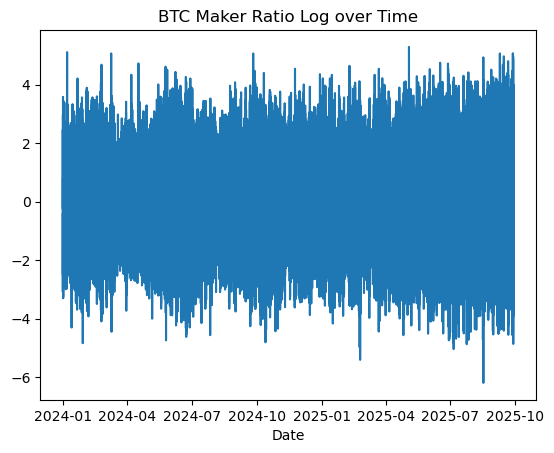

In [56]:
plt.plot(btc.index, btc['maker_ratio_log'])
plt.title('BTC Maker Ratio Log over Time')
plt.xlabel('Date')
plt.show()

### Results & Further Analysis:
- 整體上（平均）顯著，但在時間序列上波動得像沒意義。
- 在高頻下，任何單筆交易訊號的即時預測力都微弱：correlation ≈ 0.01 ~ 0.03 已經屬於高水準
- 單筆 R² ≈ 0.0001 級別，但若在一年內重複 100 萬筆交易、保持中性倉位，整體 drift > 0 就會被放大成顯著 alpha。

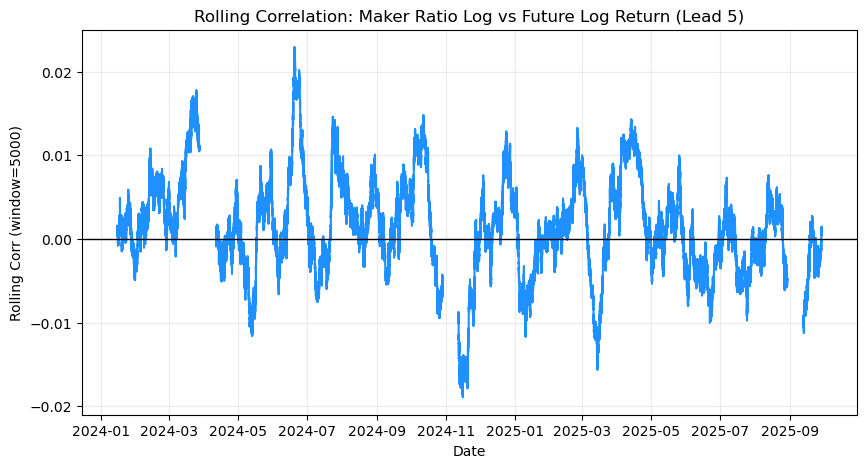

In [69]:
# 計算 rolling correlation（5000筆視窗，lead 10 bars）
btc['corr'] = btc['maker_ratio_log'].rolling(20000).corr(btc['log_return'].shift(-10))

# 畫出時間序列相關性變化
plt.figure(figsize=(10,5))
plt.plot(btc.index, btc['corr'], color='dodgerblue', lw=1.5)
plt.title('Rolling Correlation: Maker Ratio Log vs Future Log Return (Lead 5)')
plt.xlabel('Date')
plt.ylabel('Rolling Corr (window=5000)')
plt.grid(alpha=0.25)
plt.axhline(0, color='black', lw=1)
plt.show()

In [64]:
vol = btc['log_return'].rolling(200).std()
high_vol = vol > vol.quantile(0.7)
low_vol = vol < vol.quantile(0.3)

corr_high = btc.loc[high_vol, 'maker_ratio_log'].corr(btc.loc[high_vol, 'log_return'].shift(-10))
corr_low = btc.loc[low_vol, 'maker_ratio_log'].corr(btc.loc[low_vol, 'log_return'].shift(-10))

print(corr_high, corr_low)

0.0014021497951570434 0.001693594137382108


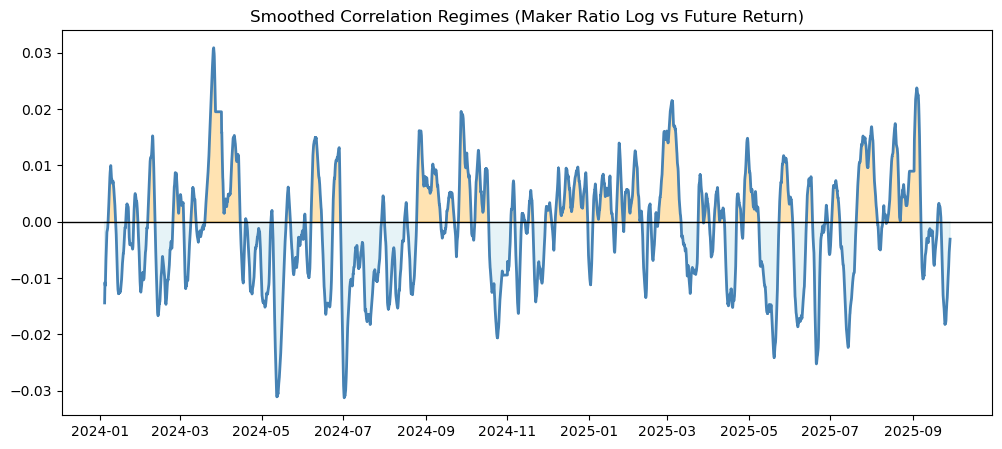

In [65]:
corr_ema = btc['corr'].ewm(span=5000).mean()

plt.figure(figsize=(12,5))
plt.plot(btc.index, corr_ema, color='steelblue', lw=2)
plt.fill_between(btc.index, 0, corr_ema, where=corr_ema>0, color='orange', alpha=0.3)
plt.fill_between(btc.index, 0, corr_ema, where=corr_ema<0, color='lightblue', alpha=0.3)
plt.title('Smoothed Correlation Regimes (Maker Ratio Log vs Future Return)')
plt.axhline(0, color='black', lw=1)
plt.show()

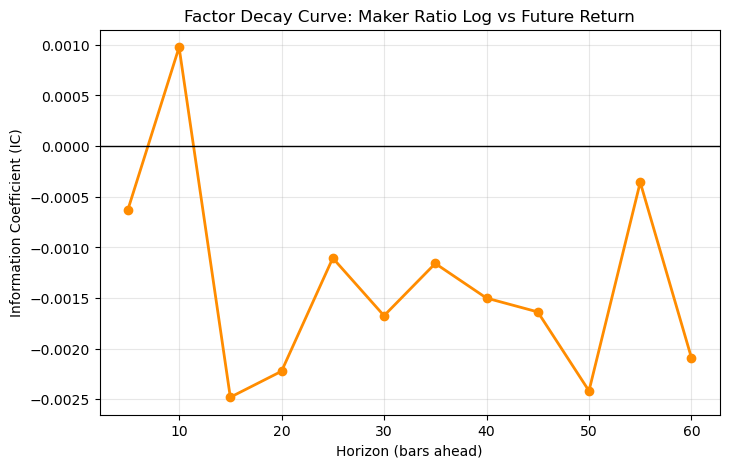

,horizon,IC
0,5,-0.000630
1,10,0.000977
2,15,-0.002479
3,20,-0.002223
4,25,-0.001105
5,30,-0.001675
6,35,-0.001159
7,40,-0.001500
8,45,-0.001637
9,50,-0.002417


In [75]:
# Factor Decay Analysis

def factor_decay_analysis(df, factor_col='maker_ratio_log', ret_col='log_return',
                          max_horizon=60, step=5):
    """
    計算因子隨時間衰減的相關係數 (Information Coefficient)
    """
    horizons = list(range(step, max_horizon+1, step))
    ic_values = []

    for h in horizons:
        shifted_ret = df[ret_col].shift(-h)
        ic = df[factor_col].corr(shifted_ret)
        ic_values.append(ic)

    decay_df = pd.DataFrame({'horizon': horizons, 'IC': ic_values})
    return decay_df


# === 執行分析 ===
decay_df = factor_decay_analysis(btc, factor_col='maker_ratio_log', ret_col='log_return',
                                 max_horizon=60, step=5)

# === 視覺化 ===
plt.figure(figsize=(8,5))
plt.plot(decay_df['horizon'], decay_df['IC'], marker='o', lw=2, color='darkorange')
plt.axhline(0, color='black', lw=1)
plt.title('Factor Decay Curve: Maker Ratio Log vs Future Return')
plt.xlabel('Horizon (bars ahead)')
plt.ylabel('Information Coefficient (IC)')
plt.grid(alpha=0.3)
plt.show()

decay_df

### Simple Backtest:
- $\text{signal}_t =
\begin{cases}
1 & \text{if } \text{maker\_ratio\_log}_t > 0 \\
-1 & \text{if } \text{maker\_ratio\_log}_t < 0 \\
0 & \text{otherwise}
\end{cases}$

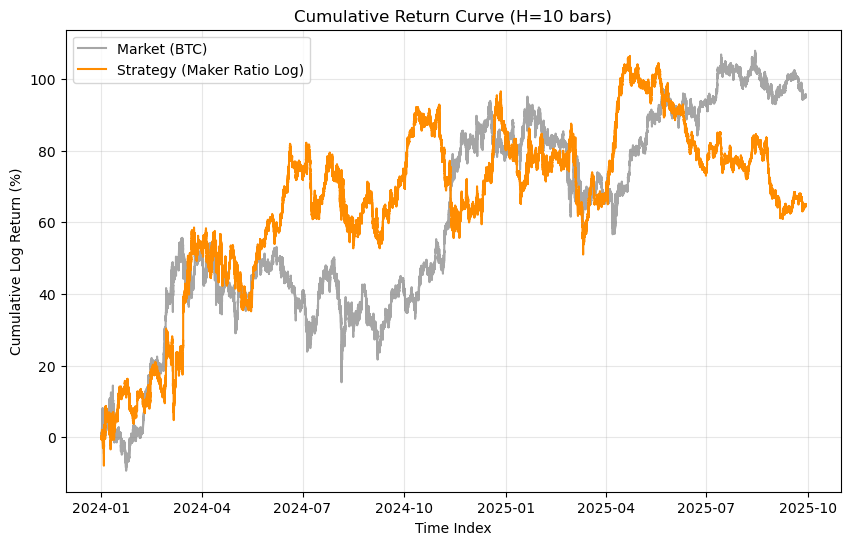

Average daily return: 0.102%
Sharpe ratio: 0.04
Win rate: 49.34%


In [86]:
df = btc.copy()

# === 1️⃣ 建立交易信號 ===
df['signal'] = 0
df.loc[df['maker_ratio_log'] > 0, 'signal'] = 1
df.loc[df['maker_ratio_log'] < 0, 'signal'] = -1

# === 2️⃣ 定義持有期（例如10 bars） ===
horizon = 10
df['future_return'] = df['log_return'].shift(-horizon)

# === 3️⃣ 計算策略報酬 ===
df['strategy_return'] = df['signal'] * df['future_return']

# === 4️⃣ 累積資金曲線 ===
df['cum_strategy'] = df['strategy_return'].cumsum()
df['cum_market'] = df['log_return'].cumsum()

# === 5️⃣ 視覺化 ===
plt.figure(figsize=(10,6))
plt.plot(df['cum_market']*100, label='Market (BTC)', color='gray', alpha=0.7)
plt.plot(df['cum_strategy']*100, label='Strategy (Maker Ratio Log)', color='darkorange')
plt.title('Cumulative Return Curve (H=10 bars)')
plt.ylabel('Cumulative Log Return (%)')
plt.xlabel('Time Index')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# === 6️⃣ 評估績效 ===
mean_ret = df['strategy_return'].mean() * 1440  # 1-min bar → daily化
vol = df['strategy_return'].std() * np.sqrt(1440)
sharpe = mean_ret / vol

winrate = (df['strategy_return'] > 0).mean()
print(f"Average daily return: {mean_ret*100:.3f}%")
print(f"Sharpe ratio: {sharpe:.2f}")
print(f"Win rate: {winrate*100:.2f}%")

- $\text{signal}_t =
\begin{cases}
1 & \text{if } \text{maker\_ratio\_log}_t < 0 \\
-1 & \text{if } \text{maker\_ratio\_log}_t > 0 \\
0 & \text{otherwise}
\end{cases}$
- Mean Reversion is a better option based on historical data
- Reason ???
- $ E[r | Q1] > E[r | Q2] > E[r | Q3] > E[r | Q4] > E[r | Q5]$ --> Ideal Situation


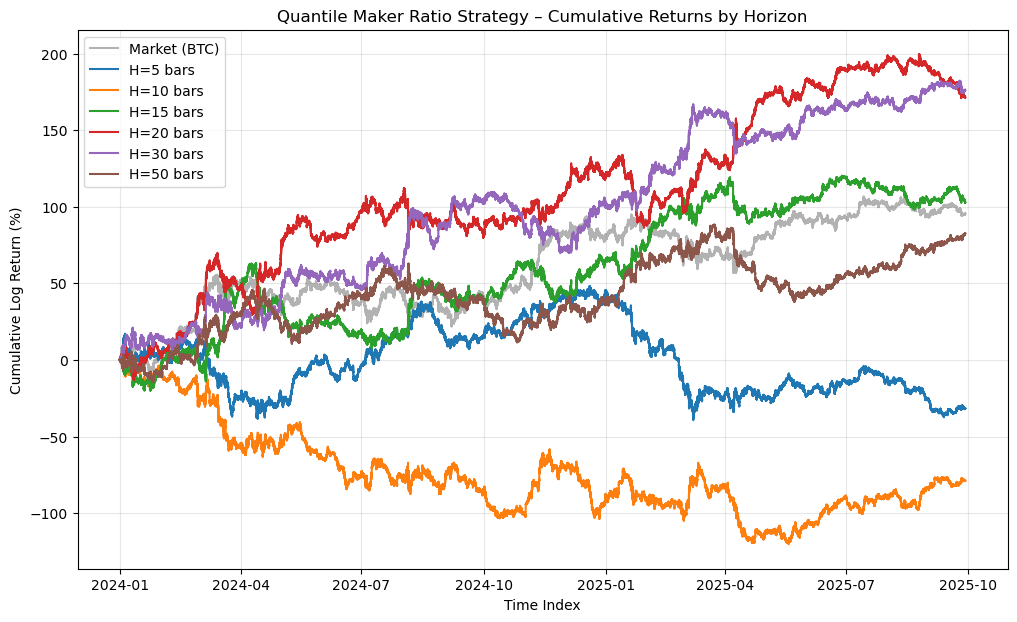

   Horizon  AvgDailyRet  Sharpe  WinRate
0        5      -0.0005 -0.0184   0.4928
1       10      -0.0012 -0.0461   0.4922
2       15       0.0016  0.0599   0.4937
3       20       0.0027  0.1000   0.4938
4       30       0.0028  0.1027   0.4936
5       50       0.0013  0.0481   0.4931


In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = btc.copy()

# === 1️⃣ 定義 signal ===
q_low, q_high = df['maker_ratio_log'].quantile([0.5, 0.5])
df['signal'] = 0
df.loc[df['maker_ratio_log'] <= q_high, 'signal'] = 1
df.loc[df['maker_ratio_log'] >= q_low, 'signal'] = -1

# === 2️⃣ 可選波動率濾網 ===
use_vol_filter = False   # 現在先關掉，觀察純信號表現
vol_window = 100
df['vol'] = df['log_return'].rolling(vol_window).std()
vol_threshold = df['vol'].quantile(0.7)
if use_vol_filter:
    df['signal'] = np.where(df['vol'] > vol_threshold, df['signal'], 0)

# === 3️⃣ Loop 多個持有期 ===
horizons = [5, 10, 15, 20, 30, 50]
results = []

plt.figure(figsize=(12,7))
plt.plot(df['log_return'].cumsum()*100, label='Market (BTC)', color='gray', alpha=0.6, lw=1.5)

for H in horizons:
    df[f'future_return_{H}'] = df['log_return'].shift(-H)
    df[f'strategy_return_{H}'] = df['signal'] * df[f'future_return_{H}']
    df[f'cum_strategy_{H}'] = df[f'strategy_return_{H}'].cumsum() * 100

    # 績效指標
    mean_ret = df[f'strategy_return_{H}'].mean() * 1440
    vol = df[f'strategy_return_{H}'].std() * np.sqrt(1440)
    sharpe = mean_ret / vol if vol > 0 else 0
    winrate = (df[f'strategy_return_{H}'] > 0).mean()
    results.append([H, mean_ret, sharpe, winrate])

    plt.plot(df[f'cum_strategy_{H}'], label=f'H={H} bars')

plt.title("Quantile Maker Ratio Strategy – Cumulative Returns by Horizon")
plt.ylabel("Cumulative Log Return (%)")
plt.xlabel("Time Index")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# === 4️⃣ 統計結果表 ===
res_df = pd.DataFrame(results, columns=['Horizon', 'AvgDailyRet', 'Sharpe', 'WinRate'])
print(res_df.round(4))

   Horizon        Q1        Q2        Q3        Q4        Q5  E[Q1]-E[Q5]
0        5  0.000003  0.000000 -0.000000  0.000002  0.000001     0.000002
1       10  0.000000 -0.000001  0.000003  0.000002  0.000002    -0.000002
2       15  0.000003  0.000003  0.000000  0.000001 -0.000003     0.000007
3       20  0.000003  0.000003  0.000000  0.000002 -0.000003     0.000005
4       30  0.000002  0.000003  0.000002 -0.000002 -0.000000     0.000003


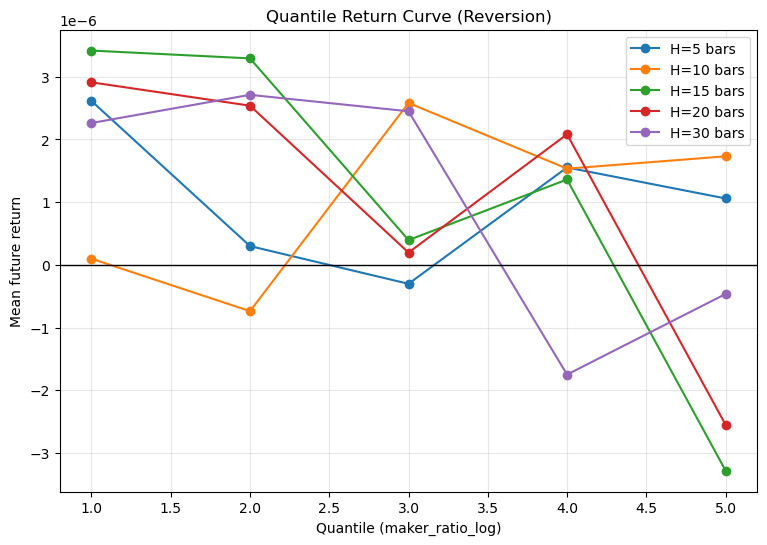

In [98]:
# === 1️⃣ 設定 quantiles ===
nq = 5  # 五分位
df['quantile'] = pd.qcut(df['maker_ratio_log'], nq, labels=False) + 1

# === 2️⃣ 設定 horizon 範圍 ===
horizons = [5, 10, 15, 20, 30]
results = []

# === 3️⃣ 計算每個 horizon 的 quantile 平均報酬 ===
for H in horizons:
    df[f'future_return_{H}'] = df['log_return'].shift(-H)
    grouped = df.groupby('quantile')[f'future_return_{H}'].mean()
    delta = grouped.iloc[0] - grouped.iloc[-1]  # E[r|Q1] - E[r|Q5]
    results.append([H, *grouped.values, delta])

# === 4️⃣ 建立結果表 ===
cols = ['Horizon'] + [f'Q{i+1}' for i in range(nq)] + ['E[Q1]-E[Q5]']
res_df = pd.DataFrame(results, columns=cols)
print(res_df.round(6))

# === 5️⃣ 視覺化 ===
plt.figure(figsize=(9,6))
for i, H in enumerate(horizons):
    plt.plot(range(1, nq+1), res_df.loc[i, 'Q1':'Q5'], marker='o', label=f'H={H} bars')

plt.title("Quantile Return Curve (Reversion)")
plt.xlabel("Quantile (maker_ratio_log)")
plt.ylabel("Mean future return")
plt.axhline(0, color='black', lw=1)
plt.legend()
plt.grid(alpha=0.3)
plt.show()

### Refinement:
- $\text{position}_t = \text{signal}t \times f{kelly,t}$


In [36]:
import pandas as pd

In [38]:
df = btc.copy()

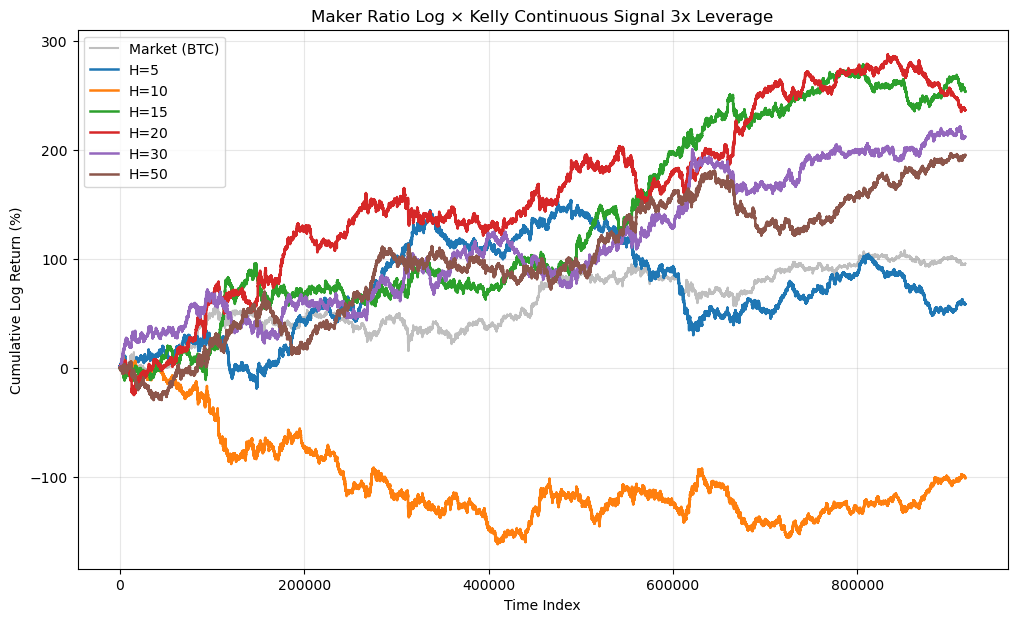

   Horizon  AvgDailyRet  Sharpe  WinRate
0        5       0.0009  0.0263   0.4928
1       10      -0.0016 -0.0456   0.4922
2       15       0.0040  0.1136   0.4937
3       20       0.0037  0.1051   0.4937
4       30       0.0033  0.0938   0.4936
5       50       0.0031  0.0859   0.4931


In [40]:
# === 1️⃣ 基本信號 ===
df['signal'] = 0
df.loc[df['maker_ratio_log'] < 0, 'signal'] = 1
df.loc[df['maker_ratio_log'] > 0, 'signal'] = -1

# === 2️⃣ 預先算 future return，用不同 horizon ===
horizons = [5, 10, 15, 20, 30, 50]

# 統計基本數據以建立 Kelly fraction
H_base = 15
df['future_ret'] = df['log_return'].shift(-H_base)
stats = df.groupby('signal')['future_ret'].agg(['mean', 'std', 'count'])
p_win = (df['future_ret'] > 0).mean()
b = abs(stats.loc[1, 'mean'] / stats.loc[-1, 'mean'])
kelly_f = p_win - (1 - p_win) / b if b > 0 else 0.1

# === 3️⃣ 動態連續信號：tanh(z-score) × Kelly fraction ===
df['z'] = (df['maker_ratio_log'] - df['maker_ratio_log'].mean()) / df['maker_ratio_log'].std()
df['kelly_pos'] = -np.tanh(df['z']) * kelly_f * 5 # 反向表示「極端掛單不平衡 → 反轉力度強」

# === 4️⃣ 多期持有 Horizon 測試 ===
results = []
plt.figure(figsize=(12,7))
plt.plot(df['log_return'].cumsum()*100, color='gray', alpha=0.5, lw=1.5, label='Market (BTC)')

for H in horizons:
    df[f'future_ret_{H}'] = df['log_return'].shift(-H)
    df[f'strategy_ret_{H}'] = df['kelly_pos'] * df[f'future_ret_{H}']
    df[f'cum_{H}'] = df[f'strategy_ret_{H}'].cumsum() * 100

    # 績效指標
    mean_ret = df[f'strategy_ret_{H}'].mean() * 1440
    vol = df[f'strategy_ret_{H}'].std() * np.sqrt(1440)
    sharpe = mean_ret / vol if vol > 0 else 0
    winrate = (df[f'strategy_ret_{H}'] > 0).mean()
    results.append([H, mean_ret, sharpe, winrate])

    plt.plot(df[f'cum_{H}'], lw=1.8, label=f'H={H}')

plt.title("Maker Ratio Log × Kelly Continuous Signal 3x Leverage")
plt.ylabel("Cumulative Log Return (%)")
plt.xlabel("Time Index")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# === 5️⃣ 統計表 ===
res_df = pd.DataFrame(results, columns=['Horizon', 'AvgDailyRet', 'Sharpe', 'WinRate'])
print(res_df.round(4))